### Importing All Necessary Libraries.

In [1]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import sklearn
import tensorflow as tf
import os
import PIL
from PIL import Image
import imagehash
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KernelDensity
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
%matplotlib inline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from tensorflow.keras.optimizers import Adam
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import ResNet50

### Loading the Data

In [2]:
train_dir = "./train"

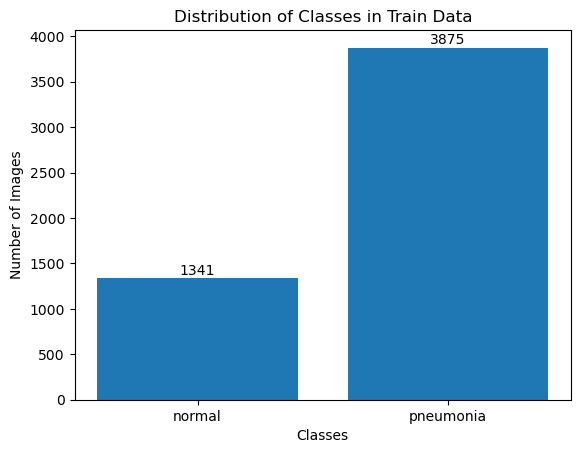

In [3]:
class_labels = os.listdir(train_dir)
class_counts = [len(os.listdir(os.path.join(train_dir, label))) for label in class_labels]

# Create the bar chart
plt.bar(class_labels, class_counts)

# Annotate each bar with its count
for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Train Data')
plt.savefig("classes_distribution")
plt.show()


In [4]:
test_dir = "./test"

In [5]:
batch_size = 20
img_height = 512
img_width = 512

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed = 123,
validation_split = 0.2,
subset = "training",
image_size = (img_height, img_width),
batch_size = batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed = 123,
validation_split = 0.2,
subset = "validation",
image_size = (img_height, img_width),
batch_size = batch_size)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed = 123,
image_size = (img_height, img_width),
batch_size = batch_size)

Found 624 files belonging to 2 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['normal', 'pneumonia']


In [10]:
num_classes = len(class_names)
print(f"The number of classes is {num_classes}.")

The number of classes is 2.


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Building Base Model

In [12]:
def train_and_get_final_metrics(model, train_dataset, val_dataset, epochs):

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs
    )

    # Get the actual number of epochs that completed
    num_epochs_completed = len(history.history["loss"])

    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    # Get the final values
    final_epoch = num_epochs_completed - 1

    final_training_loss = loss[final_epoch]
    final_training_accuracy = acc[final_epoch]
    final_validation_loss = val_loss[final_epoch]
    final_validation_accuracy = val_acc[final_epoch]

    return {
        "Final Training Loss": final_training_loss,
        "Final Training Accuracy": final_training_accuracy,
        "Final Validation Loss": final_validation_loss,
        "Final Validation Accuracy": final_validation_accuracy,
        "History": history  # Return the history object
    }

#### Using Adam activation function

In [13]:
adam_base_model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,
img_width, 3)),
layers.Conv2D(16, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(512, activation = "relu"),
Dropout(0.5),
layers.Dense(num_classes, activation = "sigmoid")
])
adam_base_model.compile(optimizer = "Adam",
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
metrics = ["accuracy"])
adam_base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1

In [14]:
adam_base_model_metrics = train_and_get_final_metrics(adam_base_model, train_ds, val_ds, epochs=10)
history = adam_base_model_metrics["History"]  # Access the history object

# Access the final metrics as callable variables
adam_loss = adam_base_model_metrics["Final Training Loss"]
adam_accuracy = adam_base_model_metrics["Final Training Accuracy"]
adam_val_loss = adam_base_model_metrics["Final Validation Loss"]
adam_val_accuracy = adam_base_model_metrics["Final Validation Accuracy"]

print()
print(f"Training Loss (Adam): {adam_loss:.2f}")
print(f"Training Accuracy (Adam): {adam_accuracy:.2f}")
print(f"Validation Loss (Adam): {adam_val_loss:.2f}")
print(f"Validation Accuracy (Adam): {adam_val_accuracy:.2f}")

Epoch 1/10
209/209 [==============================] - 25s 63ms/step - loss: 0.5660 - accuracy: 0.8871 - val_loss: 0.1113 - val_accuracy: 0.9569
Epoch 2/10
209/209 [==============================] - 12s 56ms/step - loss: 0.1099 - accuracy: 0.9609 - val_loss: 0.1089 - val_accuracy: 0.9569
Epoch 3/10
209/209 [==============================] - 12s 56ms/step - loss: 0.1167 - accuracy: 0.9547 - val_loss: 0.0488 - val_accuracy: 0.9789
Epoch 4/10
209/209 [==============================] - 12s 56ms/step - loss: 0.0661 - accuracy: 0.9775 - val_loss: 0.0764 - val_accuracy: 0.9712
Epoch 5/10
209/209 [==============================] - 12s 55ms/step - loss: 0.0393 - accuracy: 0.9851 - val_loss: 0.0475 - val_accuracy: 0.9818
Epoch 6/10
209/209 [==============================] - 12s 56ms/step - loss: 0.0252 - accuracy: 0.9916 - val_loss: 0.0399 - val_accuracy: 0.9837
Epoch 7/10
209/209 [==============================] - 12s 56ms/step - loss: 0.0158 - accuracy: 0.9940 - val_loss: 0.0636 - val_accuracy:

### Evaluating the Model

#### Making Plots for the model's loss and accuracy.

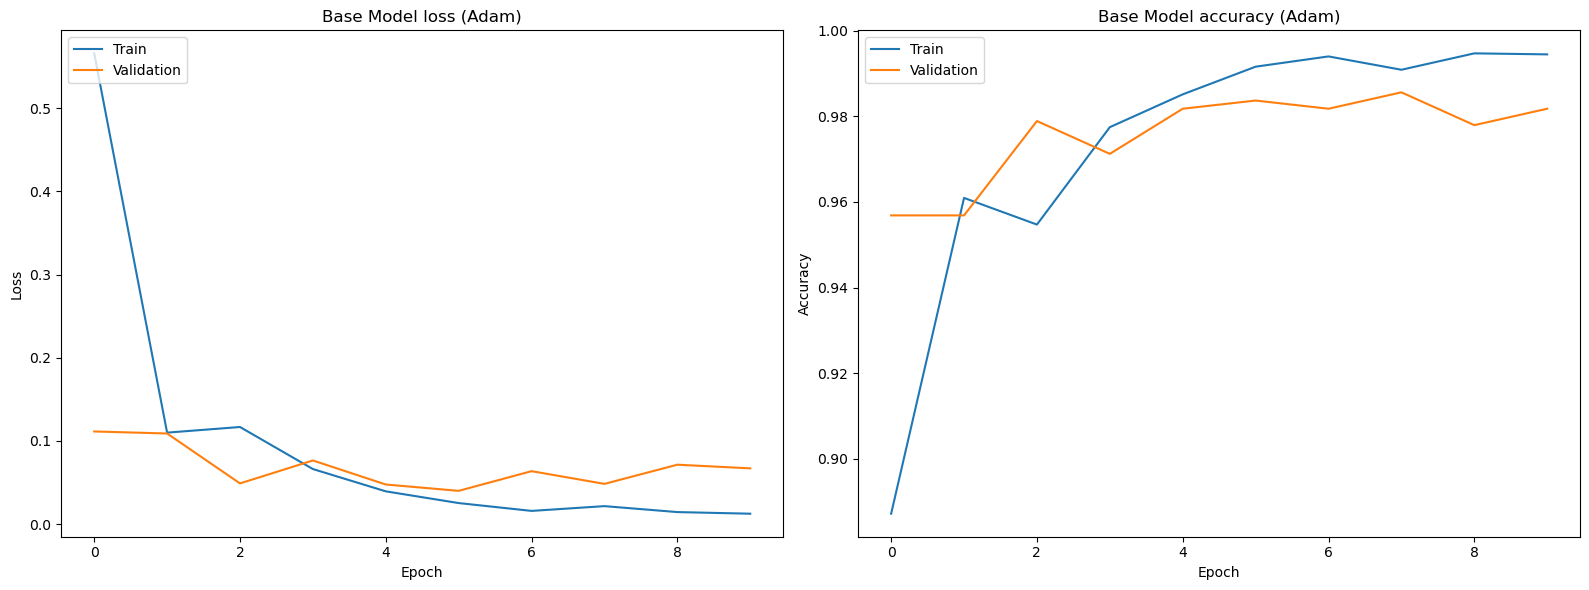

In [15]:
# Create a single figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot the first subplot (Model loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Base Model loss (Adam)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot the second subplot (Model accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Base Model accuracy (Adam)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the figure
plt.tight_layout()

# Save the figure as an image
plt.savefig("los_acc_base_model_adam")

plt.show()

#### Confusion Matrix

32/32 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

      normal       0.97      0.39      0.56       234
   pneumonia       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.77      0.74       624



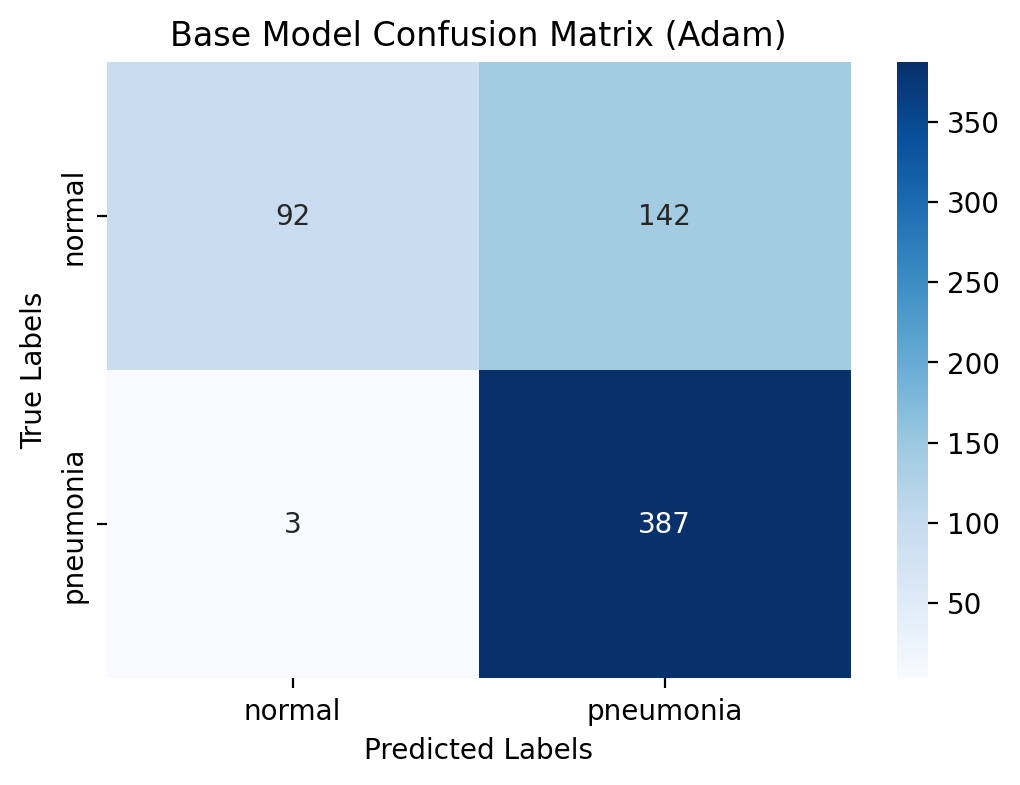

In [16]:
# Generate predictions for the test dataset
adam_base_predictions = adam_base_model.predict(test_ds)
adam_base_test_pred = np.argmax(adam_base_predictions, axis=-1)

# Extract true labels from 'test_ds'
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Map integer labels to class names for true labels
true_class_names = [class_names[label] for label in true_labels]

# Map integer labels to class names for predicted labels
predicted_class_names = [class_names[label] for label in adam_base_test_pred]

# Calculate test accuracy
base_test_accuracy_adam = accuracy_score(true_labels, adam_base_test_pred)

# Print the classification report
adam_base_report = classification_report(true_class_names, predicted_class_names, target_names=class_names)
print(adam_base_report)

# Calculate and print the confusion matrix
adam_cm = confusion_matrix(true_class_names, predicted_class_names)

# Visualize the confusion matrix using a heatmap with class labels
plt.figure(dpi=200, figsize=(6, 4))
sns.heatmap(adam_cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Base Model Confusion Matrix (Adam)')
plt.savefig("base_model_confusion_matrix_adam")
plt.show()


Base Model (Adam Activation Function):

ROC AUC Score: 0.9067
Sensitivity: 0.9923
Specificity: 0.4316


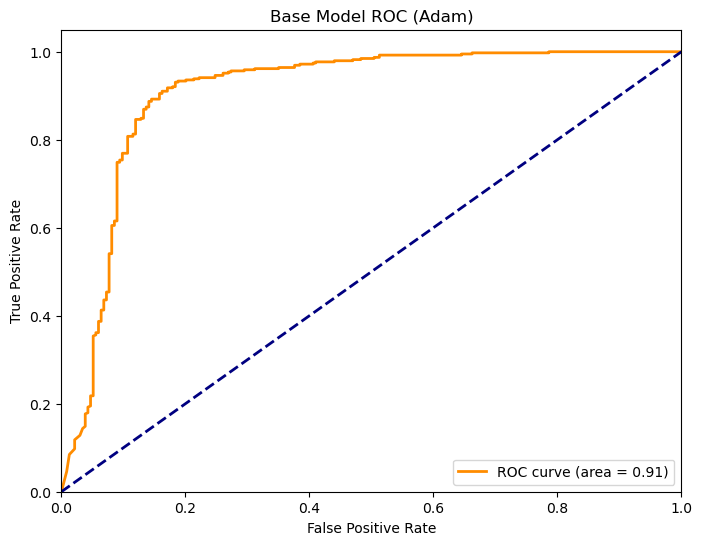

In [17]:
# Calculate the ROC curve
y_true = true_labels  # True labels
y_scores = adam_base_predictions[:, 1]  # Predicted scores (assuming binary classification)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calculate ROC AUC
adam_roc_auc_score_value = roc_auc_score(y_true, y_scores)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true, np.round(y_scores)).ravel()

adam_sensitivity = tp / (tp + fn)
adam_specificity = tn / (tn + fp)

print("Base Model (Adam Activation Function):")
print()
print(f"ROC AUC Score: {adam_roc_auc_score_value:.4f}")
print(f"Sensitivity: {adam_sensitivity:.4f}")
print(f"Specificity: {adam_specificity:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Base Model ROC (Adam)')
plt.legend(loc='lower right')
plt.savefig("base_model_roc_curve_adam.png")
plt.show()


#### Using SGD activation function

In [18]:
sgd_base_model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,
img_width, 3)),
layers.Conv2D(16, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(512, activation = "relu"),
Dropout(0.5),
layers.Dense(num_classes, activation = "sigmoid")
])
sgd_base_model.compile(optimizer = "SGD",
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
metrics = ["accuracy"])
sgd_base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)     

In [19]:
sgd_base_model_metrics = train_and_get_final_metrics(sgd_base_model, train_ds, val_ds, epochs=10)
history = sgd_base_model_metrics["History"]  # Access the history object

# Access the final metrics as callable variables
sgd_loss = sgd_base_model_metrics["Final Training Loss"]
sgd_accuracy = sgd_base_model_metrics["Final Training Accuracy"]
sgd_val_loss = sgd_base_model_metrics["Final Validation Loss"]
sgd_val_accuracy = sgd_base_model_metrics["Final Validation Accuracy"]

print()
print(f"Training Loss (SGD): {sgd_loss:.2f}")
print(f"Training Accuracy (SGD): {sgd_accuracy:.2f}")
print(f"Validation Loss (SGD): {sgd_val_loss:.2f}")
print(f"Validation Accuracy (SGD): {sgd_val_accuracy:.2f}")

Epoch 1/10
209/209 [==============================] - 15s 55ms/step - loss: 0.4425 - accuracy: 0.8061 - val_loss: 0.1992 - val_accuracy: 0.9338
Epoch 2/10
209/209 [==============================] - 11s 53ms/step - loss: 0.2045 - accuracy: 0.9226 - val_loss: 0.1375 - val_accuracy: 0.9386
Epoch 3/10
209/209 [==============================] - 11s 53ms/step - loss: 0.1439 - accuracy: 0.9456 - val_loss: 0.0851 - val_accuracy: 0.9703
Epoch 4/10
209/209 [==============================] - 11s 55ms/step - loss: 0.1150 - accuracy: 0.9590 - val_loss: 0.0761 - val_accuracy: 0.9693
Epoch 5/10
209/209 [==============================] - 11s 54ms/step - loss: 0.1082 - accuracy: 0.9612 - val_loss: 0.0683 - val_accuracy: 0.9770
Epoch 6/10
209/209 [==============================] - 11s 54ms/step - loss: 0.0982 - accuracy: 0.9626 - val_loss: 0.0653 - val_accuracy: 0.9751
Epoch 7/10
209/209 [==============================] - 11s 54ms/step - loss: 0.0851 - accuracy: 0.9669 - val_loss: 0.0584 - val_accuracy:

### Evaluating the Model

#### Making Plots for the model's loss and accuracy.

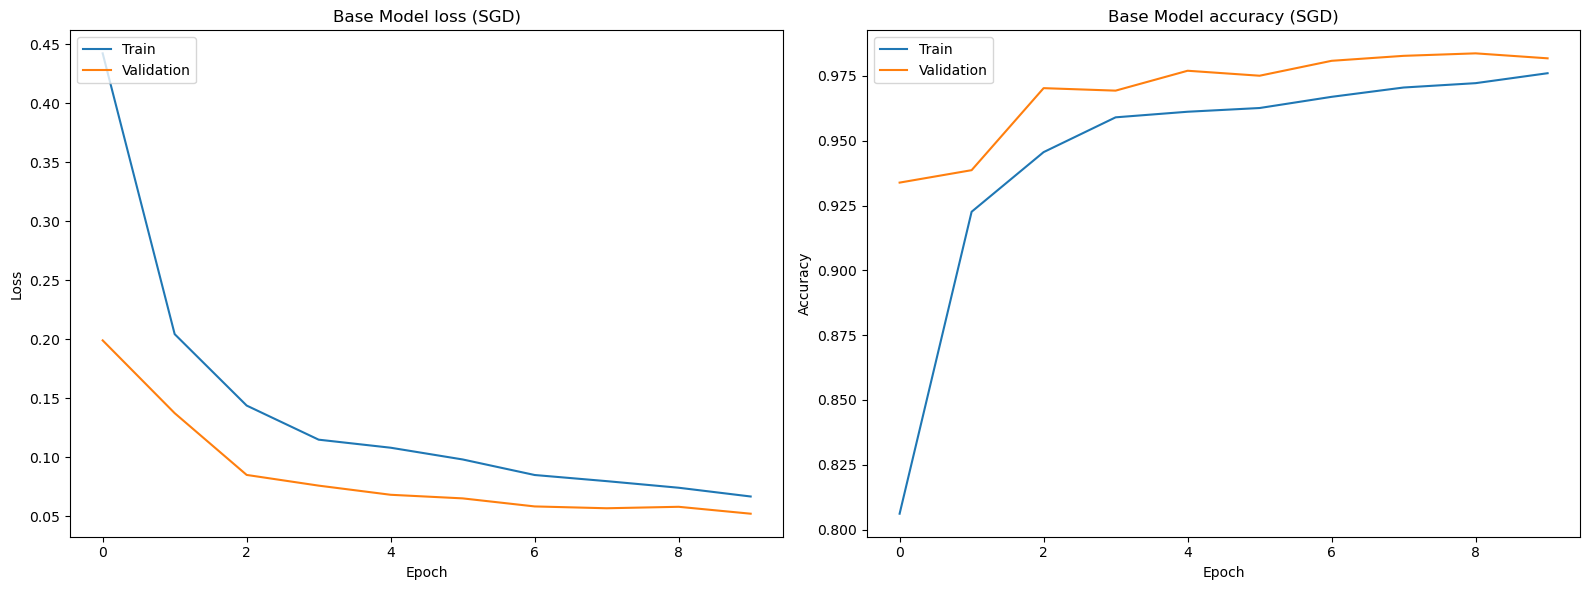

In [20]:
# Create a single figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot the first subplot (Model loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Base Model loss (SGD)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot the second subplot (Model accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Base Model accuracy (SGD)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the figure
plt.tight_layout()

# Save the figure as an image
plt.savefig("los_acc_base_model_SGD")

plt.show()

#### Confusion Matrix

32/32 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

      normal       0.96      0.45      0.62       234
   pneumonia       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.74       624
weighted avg       0.83      0.79      0.76       624



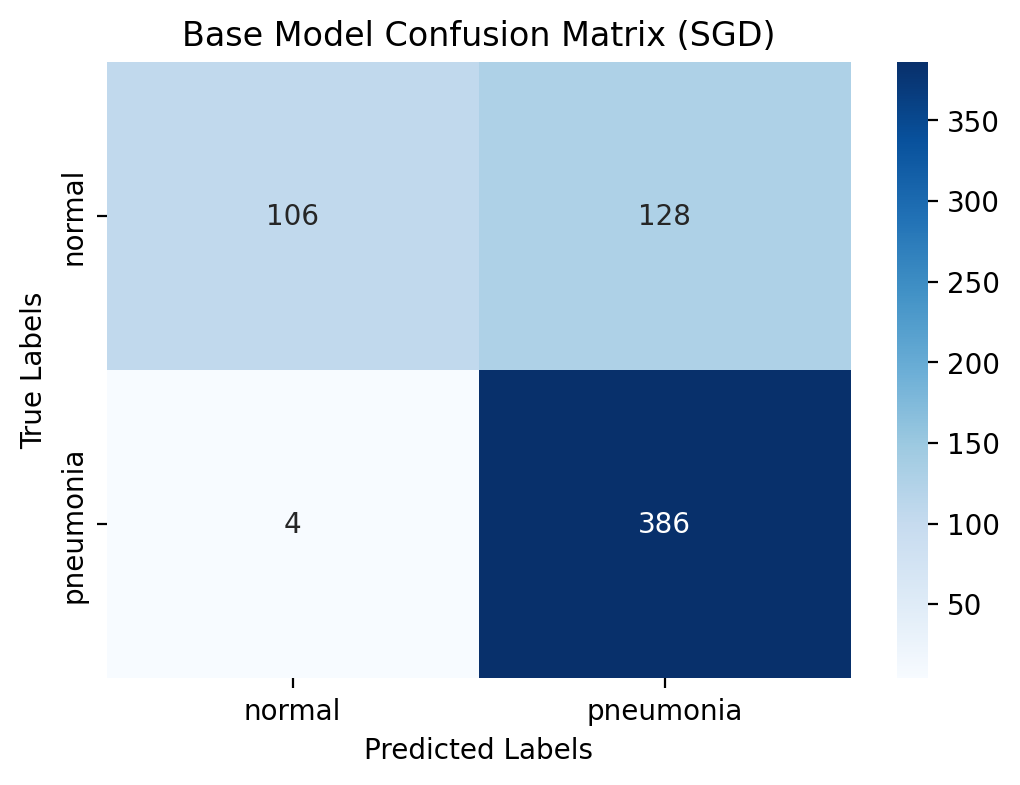

In [21]:
# Generate predictions for the test dataset
sgd_base_predictions = sgd_base_model.predict(test_ds)
sgd_base_test_pred = np.argmax(sgd_base_predictions, axis=-1)

# Extract true labels from 'test_ds'
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Map integer labels to class names for true labels
true_class_names = [class_names[label] for label in true_labels]

# Map integer labels to class names for predicted labels
predicted_class_names = [class_names[label] for label in sgd_base_test_pred]

# Calculate test accuracy
base_test_accuracy_sgd = accuracy_score(true_labels, sgd_base_test_pred)

# Print the classification report
sgd_base_report = classification_report(true_class_names, predicted_class_names, target_names=class_names)
print(sgd_base_report)

# Calculate and print the confusion matrix
sgd_cm = confusion_matrix(true_class_names, predicted_class_names)

# Visualize the confusion matrix using a heatmap with class labels
plt.figure(dpi=200, figsize=(6, 4))
sns.heatmap(sgd_cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Base Model Confusion Matrix (SGD)')
plt.savefig("sgd_baseline_confusion_matrix")
plt.show()



Base Model (SGD Activation Function):
ROC AUC Score: 0.9253
Sensitivity: 0.9821
Specificity: 0.5299


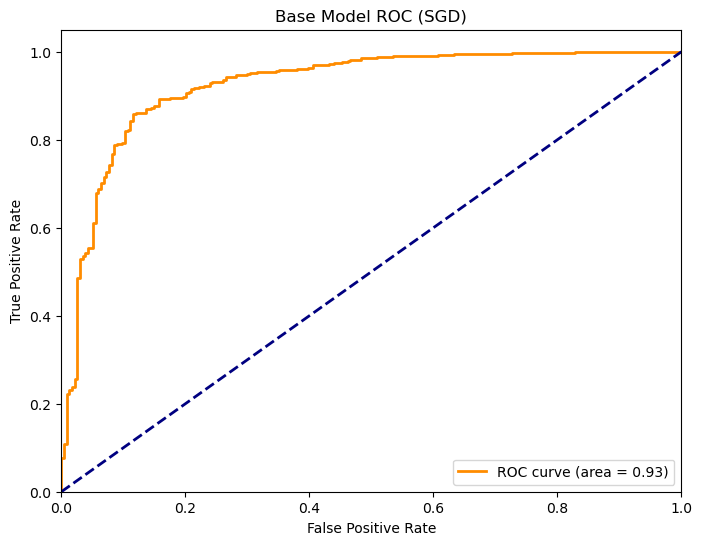

In [22]:
# Calculate the ROC curve
y_true = true_labels  # True labels
y_scores = sgd_base_predictions[:, 1]  # Predicted scores (assuming binary classification)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calculate ROC AUC
sgd_roc_auc_score_value = roc_auc_score(y_true, y_scores)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true, np.round(y_scores)).ravel()

sgd_sensitivity = tp / (tp + fn)
sgd_specificity = tn / (tn + fp)

print()
print("Base Model (SGD Activation Function):")
print(f"ROC AUC Score: {sgd_roc_auc_score_value:.4f}")
print(f"Sensitivity: {sgd_sensitivity:.4f}")
print(f"Specificity: {sgd_specificity:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Base Model ROC (SGD)')
plt.legend(loc='lower right')
plt.savefig("sgd_roc_curve.png")
plt.show()


#### Using RMSProp activation function

In [23]:
rms_base_model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,
img_width, 3)),
layers.Conv2D(16, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(512, activation = "relu"),
Dropout(0.5),
layers.Dense(num_classes, activation = "sigmoid")
])
rms_base_model.compile(optimizer = "RMSProp",
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
metrics = ["accuracy"])
rms_base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)     

In [24]:
rms_base_model_metrics = train_and_get_final_metrics(rms_base_model, train_ds, val_ds, epochs=10)
history = rms_base_model_metrics["History"]  # Access the history object

# Access the final metrics as callable variables
rms_loss = rms_base_model_metrics["Final Training Loss"]
rms_accuracy = rms_base_model_metrics["Final Training Accuracy"]
rms_val_loss = rms_base_model_metrics["Final Validation Loss"]
rms_val_accuracy = rms_base_model_metrics["Final Validation Accuracy"]

print()
print(f"Training Loss (RMSProp): {rms_loss:.2f}")
print(f"Training Accuracy (RMSProp): {rms_accuracy:.2f}")
print(f"Validation Loss (RMSProp): {rms_val_loss:.2f}")
print(f"Validation Accuracy (RMSProp): {rms_val_accuracy:.2f}")

Epoch 1/10
209/209 [==============================] - 16s 55ms/step - loss: 0.7573 - accuracy: 0.8351 - val_loss: 0.1551 - val_accuracy: 0.9377
Epoch 2/10
209/209 [==============================] - 11s 54ms/step - loss: 0.1841 - accuracy: 0.9248 - val_loss: 0.0865 - val_accuracy: 0.9703
Epoch 3/10
209/209 [==============================] - 11s 53ms/step - loss: 0.1042 - accuracy: 0.9588 - val_loss: 0.0641 - val_accuracy: 0.9722
Epoch 4/10
209/209 [==============================] - 11s 53ms/step - loss: 0.0801 - accuracy: 0.9696 - val_loss: 0.0785 - val_accuracy: 0.9664
Epoch 5/10
209/209 [==============================] - 11s 54ms/step - loss: 0.0575 - accuracy: 0.9827 - val_loss: 0.0541 - val_accuracy: 0.9827
Epoch 6/10
209/209 [==============================] - 11s 53ms/step - loss: 0.0394 - accuracy: 0.9875 - val_loss: 0.0555 - val_accuracy: 0.9847
Epoch 7/10
209/209 [==============================] - 11s 54ms/step - loss: 0.0270 - accuracy: 0.9931 - val_loss: 0.0655 - val_accuracy:

### Evaluating the Model

#### Making Plots for the model's loss and accuracy.

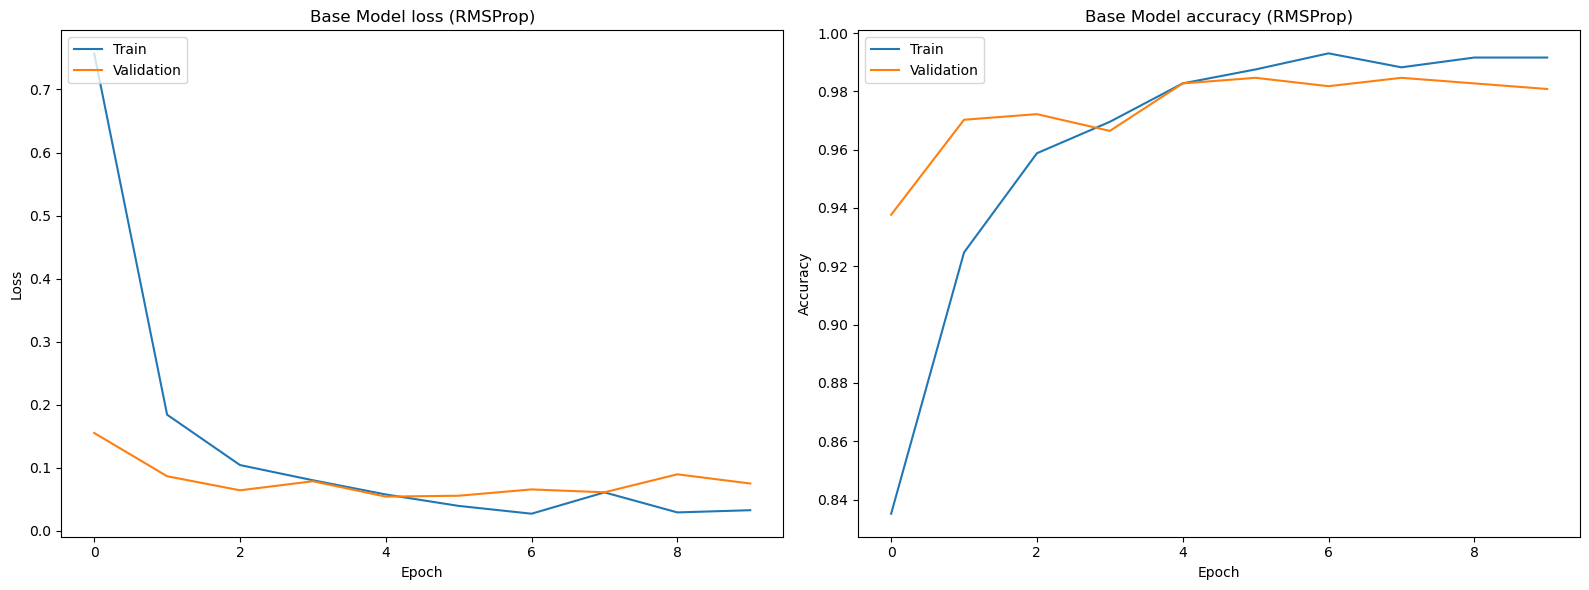

In [25]:
# Create a single figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot the first subplot (Model loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Base Model loss (RMSProp)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot the second subplot (Model accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Base Model accuracy (RMSProp)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the figure
plt.tight_layout()

# Save the figure as an image
plt.savefig("baseline_model_RMSProp")

plt.show()

#### Confusion Matrix

32/32 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

      normal       0.97      0.41      0.58       234
   pneumonia       0.74      0.99      0.85       390

    accuracy                           0.77       624
   macro avg       0.85      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



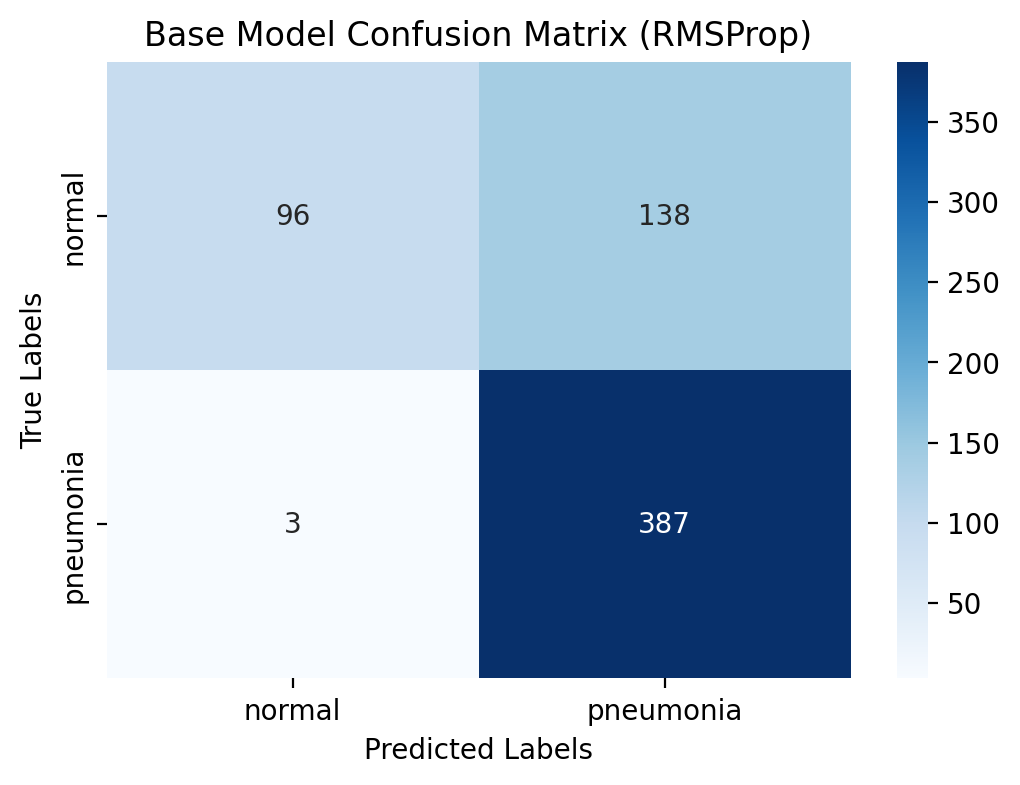

In [26]:
# Generate predictions for the test dataset
rms_base_predictions = rms_base_model.predict(test_ds)
rms_base_test_pred = np.argmax(rms_base_predictions, axis=-1)

# Extract true labels from 'test_ds'
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Map integer labels to class names for true labels
true_class_names = [class_names[label] for label in true_labels]

# Map integer labels to class names for predicted labels
predicted_class_names = [class_names[label] for label in rms_base_test_pred]

# Calculate test accuracy
base_test_accuracy_rms = accuracy_score(true_labels, rms_base_test_pred)

# Print the classification report
rms_base_report = classification_report(true_class_names, predicted_class_names, target_names=class_names)
print(rms_base_report)

# Calculate and print the confusion matrix
rms_cm = confusion_matrix(true_class_names, predicted_class_names)

# Visualize the confusion matrix using a heatmap with class labels
plt.figure(dpi=200, figsize=(6, 4))
sns.heatmap(rms_cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Base Model Confusion Matrix (RMSProp)')
plt.savefig("RMSProp_baseline_confusion_matrix")
plt.show()


ROC AUC Score: 0.9116
Sensitivity: 0.9897
Specificity: 0.4359


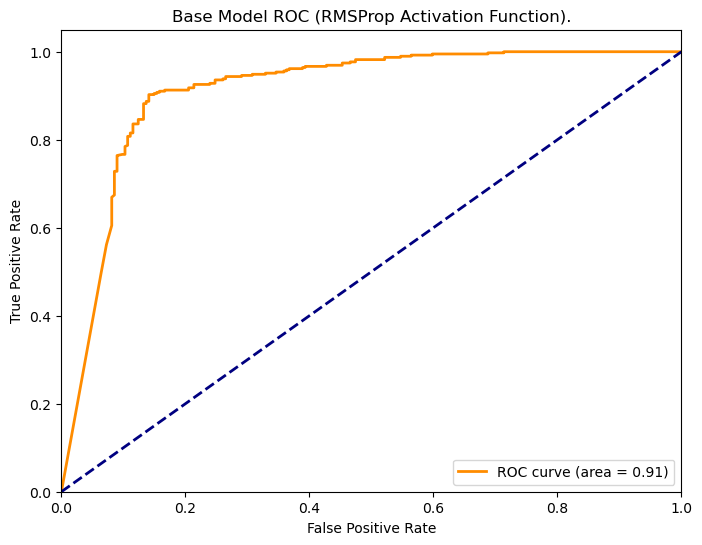

In [27]:
# Calculate the ROC curve
y_true = true_labels  # True labels
y_scores = rms_base_predictions[:, 1]  # Predicted scores (assuming binary classification)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calculate ROC AUC
rms_roc_auc_score_value = roc_auc_score(y_true, y_scores)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true, np.round(y_scores)).ravel()

rms_sensitivity = tp / (tp + fn)
rms_specificity = tn / (tn + fp)

print(f"ROC AUC Score: {rms_roc_auc_score_value:.4f}")
print(f"Sensitivity: {rms_sensitivity:.4f}")
print(f"Specificity: {rms_specificity:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Base Model ROC (RMSProp Activation Function).')
plt.legend(loc='lower right')
plt.savefig("rms_roc_curve.png")
plt.show()


#### Evaluating the base models.

In [35]:
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:.2f}", xy = (bar.get_x() + bar.get_width() / 2 , height),
                    xytext = (0, 3), textcoords = "offset points", 
                    ha = "center", va = "bottom")

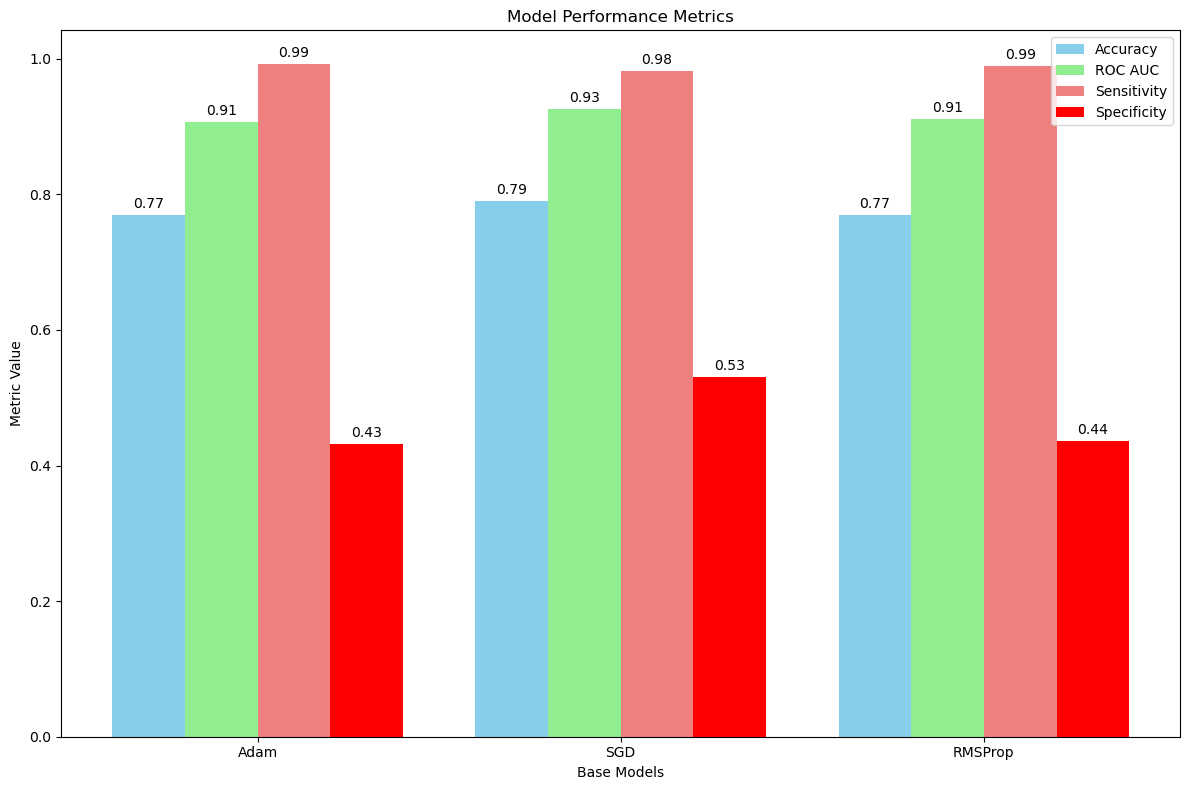

In [37]:
# Base model names
base_models = ["Adam", "SGD", "RMSProp"]

# Metrics
accuracy_list = [base_test_accuracy_adam, base_test_accuracy_sgd, base_test_accuracy_rms]
roc_auc_list = [adam_roc_auc_score_value, sgd_roc_auc_score_value, rms_roc_auc_score_value]
sensitivity_list = [adam_sensitivity, sgd_sensitivity, rms_sensitivity]
specificity_list = [adam_specificity, sgd_specificity, rms_specificity]

# Setting the width of the bars
bar_width = 0.2
index = range(len(base_models))

# Creating subplots for each metric
plt.figure(figsize = (12, 8))

# Plotting Accuracy
bar1 = plt.bar(index, accuracy_list, bar_width, label = "Accuracy", color = "skyblue", align = "center")
add_values(bar1)

# Plotting ROC AUC
bar2 = plt.bar([i + bar_width for i in index], roc_auc_list, bar_width, label = "ROC AUC", color = "lightgreen", 
               align = "center")
add_values(bar2)

# Plotting Sensitivity
bar3 = plt.bar([i + 2 * bar_width for i in index], sensitivity_list, bar_width, label = "Sensitivity", 
               color = "lightcoral", align = "center")
add_values(bar3)

# Plotting ROC AUC
bar4 = plt.bar([i + 3 * bar_width for i in index], specificity_list, bar_width, label = "Specificity", color = "red", 
               align = "center")
add_values(bar4)

# Setting the x-axis labels
plt.xlabel("Base Models")
plt.xticks([i + 1.5 * bar_width for i in index], base_models)

# Setting the y-axis labels
plt.ylabel("Metric Value")

# Setting the plot title
plt.title("Model Performance Metrics")

# Setting the plot title
plt.legend()

# Showing the plot
plt.tight_layout()
plt.savefig("base_final_metric_comparism")
plt.show()

Accuracy, ROC AUC, sensitivity and specificity of the three baseline models, the model with SGD activation function performed the best and would be selected for hyperparameter tuning.

### Hyperparameter Tuning

#### Using RMSProp Activation Function

In [63]:
cnn_model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,
img_width, 3)),
layers.Conv2D(16, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),

layers.Flatten(),
layers.Dense(128, activation = "relu"),
Dropout(0.9),
layers.Dense(num_classes, activation = "sigmoid")
])

initial_learning_rate = 0.001

optimizer = RMSprop(learning_rate=initial_learning_rate)

cnn_model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"])
cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 128, 128, 64)     

In [64]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)  # adjust the value as needed

In [65]:
lr_schedule = LearningRateScheduler(scheduler)

In [66]:
# Initialize an empty list to collect class labels
class_labels = []

# Iterate through the dataset to collect labels
for _, labels in train_ds.as_numpy_iterator():
    class_labels.extend(labels)

# Convert class labels to a NumPy array
class_labels = np.array(class_labels)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weight_dict = dict(enumerate(class_weights))

In [67]:
def early_train_and_get_final_metrics(model, train_dataset, val_dataset, epochs, patience):
    early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs, 
        callbacks=[early_stopping, lr_schedule],  # Use this for LearningRateScheduler
        class_weight = class_weight_dict
    )

    # Get the actual number of epochs that completed
    num_epochs_completed = len(history.history["loss"])

    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    # Get the final values
    final_epoch = num_epochs_completed - 1

    final_training_loss = loss[final_epoch]
    final_training_accuracy = acc[final_epoch]
    final_validation_loss = val_loss[final_epoch]
    final_validation_accuracy = val_acc[final_epoch]

    return {
        "Final Training Loss": final_training_loss,
        "Final Training Accuracy": final_training_accuracy,
        "Final Validation Loss": final_validation_loss,
        "Final Validation Accuracy": final_validation_accuracy,
        "History": history  # Return the history object
    }

In [68]:
cnn_final_metrics = early_train_and_get_final_metrics(cnn_model, train_ds, val_ds, epochs=10, patience=3)

# Access the final metrics as callable variables
cnn_loss = cnn_final_metrics["Final Training Loss"]
cnn_accuracy = cnn_final_metrics["Final Training Accuracy"]
cnn_val_loss = cnn_final_metrics["Final Validation Loss"]
cnn_val_accuracy = cnn_final_metrics["Final Validation Accuracy"]

print(f"Training Loss (CNN): {cnn_loss:.2f}")
print(f"Training Accuracy (CNN): {cnn_accuracy:.2f}")
print(f"Validation Loss (CNN): {cnn_val_loss:.2f}")
print(f"Validation Accuracy (CNN): {cnn_val_accuracy:.2f}")
history = cnn_final_metrics["History"]

Epoch 1/10
209/209 [==============================] - 11s 45ms/step - loss: 0.6267 - accuracy: 0.7906 - val_loss: 0.2632 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 2/10
209/209 [==============================] - 9s 45ms/step - loss: 0.3401 - accuracy: 0.8411 - val_loss: 0.1712 - val_accuracy: 0.9406 - lr: 0.0010
Epoch 3/10
209/209 [==============================] - 9s 45ms/step - loss: 0.2766 - accuracy: 0.8938 - val_loss: 0.1140 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 4/10
209/209 [==============================] - 9s 45ms/step - loss: 0.2250 - accuracy: 0.9156 - val_loss: 0.0940 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 5/10
209/209 [==============================] - 9s 45ms/step - loss: 0.2544 - accuracy: 0.9226 - val_loss: 0.1245 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 6/10
209/209 [==============================] - 9s 45ms/step - loss: 0.1965 - accuracy: 0.9360 - val_loss: 0.0902 - val_accuracy: 0.9674 - lr: 9.0484e-04
Epoch 7/10
209/209 [==============================] - 9s 45

### Evaluating the Model

#### Making Plots for the model's loss and accuracy.

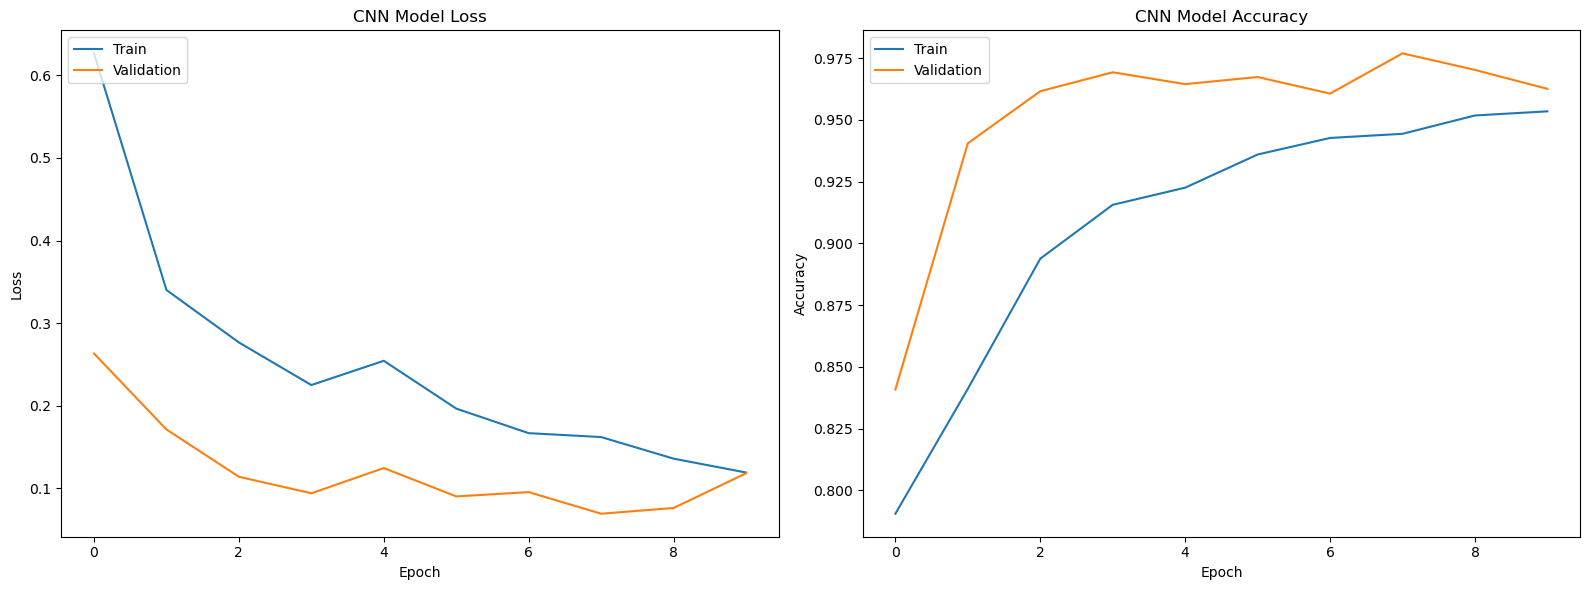

In [69]:
# Create a single figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot the first subplot (Model loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot the second subplot (Model accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the figure
plt.tight_layout()

# Save the figure as an image
plt.savefig("cnn_model_rms")

plt.show()

#### Confusion Matrix

32/32 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

      normal       0.93      0.57      0.71       234
   pneumonia       0.79      0.97      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624



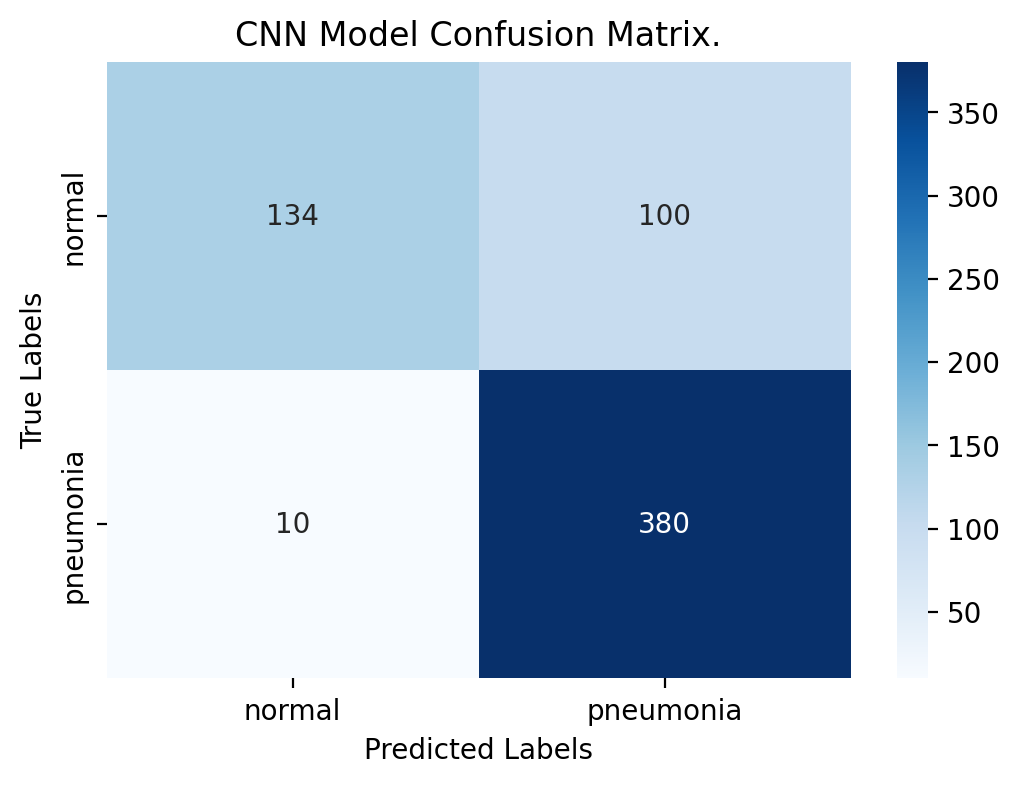

In [70]:
# Generate predictions for the test dataset
cnn_predictions = cnn_model.predict(test_ds)
cnn_test_pred = np.argmax(cnn_predictions, axis=-1)

# Extract true labels from 'test_ds'
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Map integer labels to class names for true labels
true_class_names = [class_names[label] for label in true_labels]

# Map integer labels to class names for predicted labels
predicted_class_names = [class_names[label] for label in cnn_test_pred]

# Calculate test accuracy
cnn_test_accuracy_rms = accuracy_score(true_labels, cnn_test_pred)

# Print the classification report
cnn_report = classification_report(true_class_names, predicted_class_names, target_names=class_names)
print(cnn_report)

# Calculate and print the confusion matrix
cm_cnn = confusion_matrix(true_class_names, predicted_class_names)

# Visualize the confusion matrix using a heatmap with class labels
plt.figure(dpi=200, figsize=(6, 4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Model Confusion Matrix.')
plt.savefig("cnn_confusion_matrix_rms")
plt.show()


CNN Model:

ROC AUC Score: 0.9101
Sensitivity: 0.9744
Specificity: 0.5684


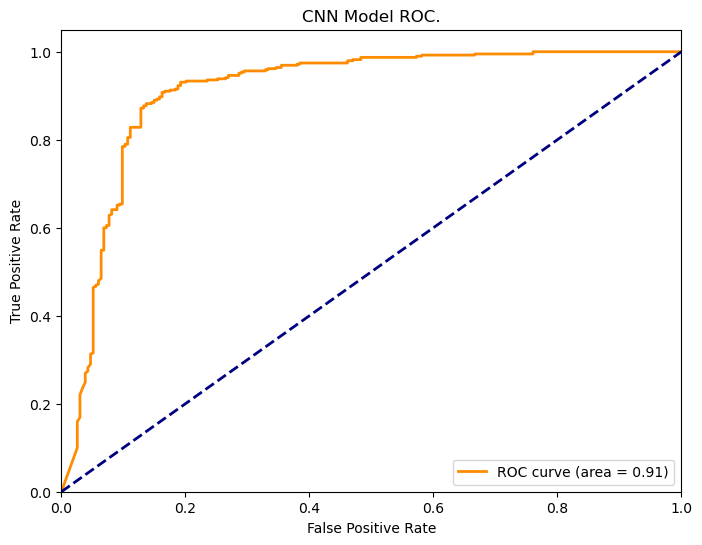

In [72]:
# Calculate the ROC curve
y_true = true_labels  # True labels
y_scores = cnn_predictions[:, 1]  # Predicted scores (assuming binary classification)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calculate ROC AUC
cnn_roc_auc_score_value = roc_auc_score(y_true, y_scores)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true, np.round(y_scores)).ravel()

cnn_sensitivity = tp / (tp + fn)
cnn_specificity = tn / (tn + fp)

print("CNN Model:")
print()
print(f"ROC AUC Score: {cnn_roc_auc_score_value:.4f}")
print(f"Sensitivity: {cnn_sensitivity:.4f}")
print(f"Specificity: {cnn_specificity:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Model ROC.')
plt.legend(loc='lower right')
plt.savefig("cnn_roc_curve_rms.png")
plt.show()


#### Using Adam Activation Function

In [73]:
cnn_model_2 = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,
img_width, 3)),
layers.Conv2D(16, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),

layers.Flatten(),
layers.Dense(128, activation = "relu"),
Dropout(0.9),
layers.Dense(num_classes, activation = "sigmoid")
])

initial_learning_rate = 0.001

optimizer = Adam(learning_rate=initial_learning_rate)

cnn_model_2.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"])
cnn_model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 512, 512, 3)       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 128, 128, 64)    

In [78]:
cnn_final_metrics_2 = early_train_and_get_final_metrics(cnn_model_2, train_ds, val_ds, epochs=10, patience=3)

# Access the final metrics as callable variables
cnn_loss_2 = cnn_final_metrics_2["Final Training Loss"]
cnn_accuracy_2 = cnn_final_metrics_2["Final Training Accuracy"]
cnn_val_loss_2 = cnn_final_metrics_2["Final Validation Loss"]
cnn_val_accuracy_2 = cnn_final_metrics_2["Final Validation Accuracy"]

print(f"Training Loss (CNN): {cnn_loss_2:.2f}")
print(f"Training Accuracy (CNN): {cnn_accuracy_2:.2f}")
print(f"Validation Loss (CNN): {cnn_val_loss_2:.2f}")
print(f"Validation Accuracy (CNN): {cnn_val_accuracy_2:.2f}")
history = cnn_final_metrics_2["History"]

Epoch 1/10
209/209 [==============================] - 11s 46ms/step - loss: 0.6962 - accuracy: 0.7939 - val_loss: 0.3084 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 2/10
209/209 [==============================] - 9s 45ms/step - loss: 0.3705 - accuracy: 0.8279 - val_loss: 0.2208 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 3/10
209/209 [==============================] - 9s 45ms/step - loss: 0.2892 - accuracy: 0.8569 - val_loss: 0.1884 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 4/10
209/209 [==============================] - 9s 45ms/step - loss: 0.2554 - accuracy: 0.8816 - val_loss: 0.1242 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 5/10
209/209 [==============================] - 9s 45ms/step - loss: 0.2019 - accuracy: 0.9106 - val_loss: 0.1183 - val_accuracy: 0.9501 - lr: 0.0010
Epoch 6/10
209/209 [==============================] - 9s 44ms/step - loss: 0.1840 - accuracy: 0.9260 - val_loss: 0.1331 - val_accuracy: 0.9463 - lr: 9.0484e-04
Epoch 7/10
209/209 [==============================] - 9s 45

### Evaluating the Model

#### Making Plots for the model's loss and accuracy.

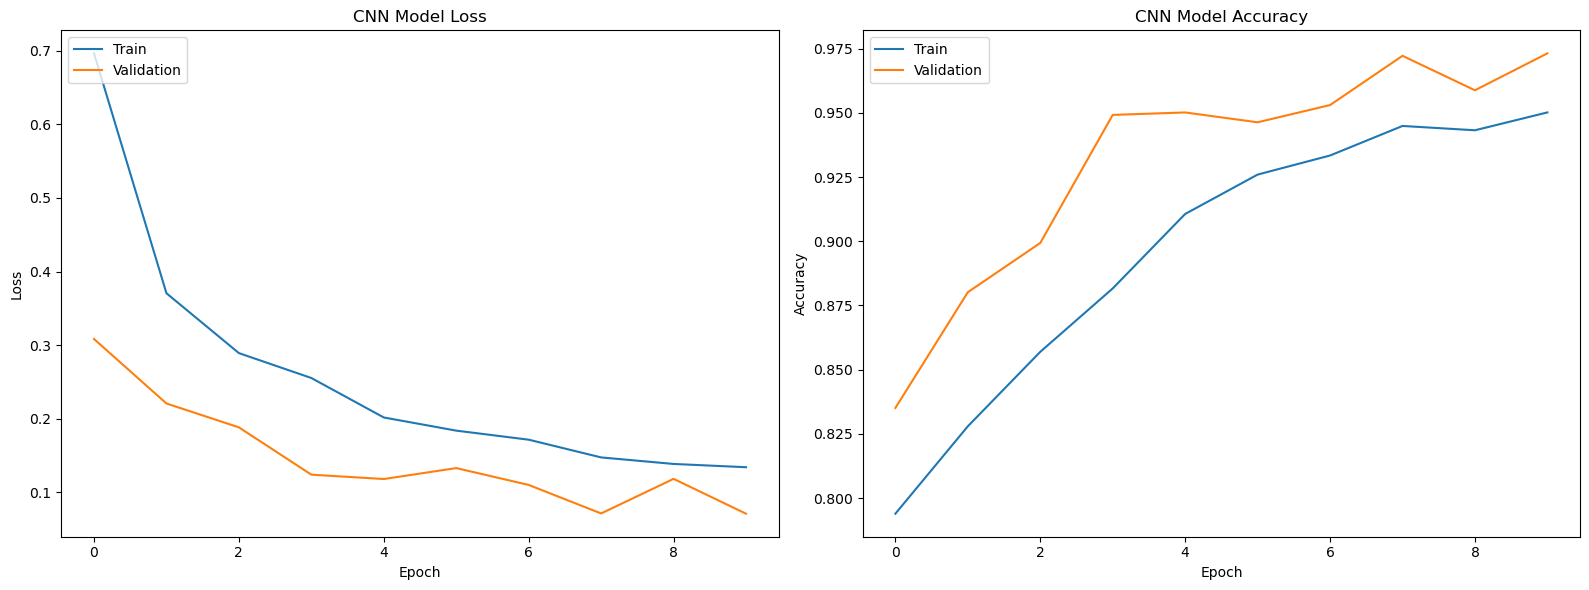

In [79]:
# Create a single figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot the first subplot (Model loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot the second subplot (Model accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the figure
plt.tight_layout()

# Save the figure as an image
plt.savefig("cnn_model_adam")

plt.show()

#### Confusion Matrix

32/32 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

      normal       0.93      0.49      0.64       234
   pneumonia       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



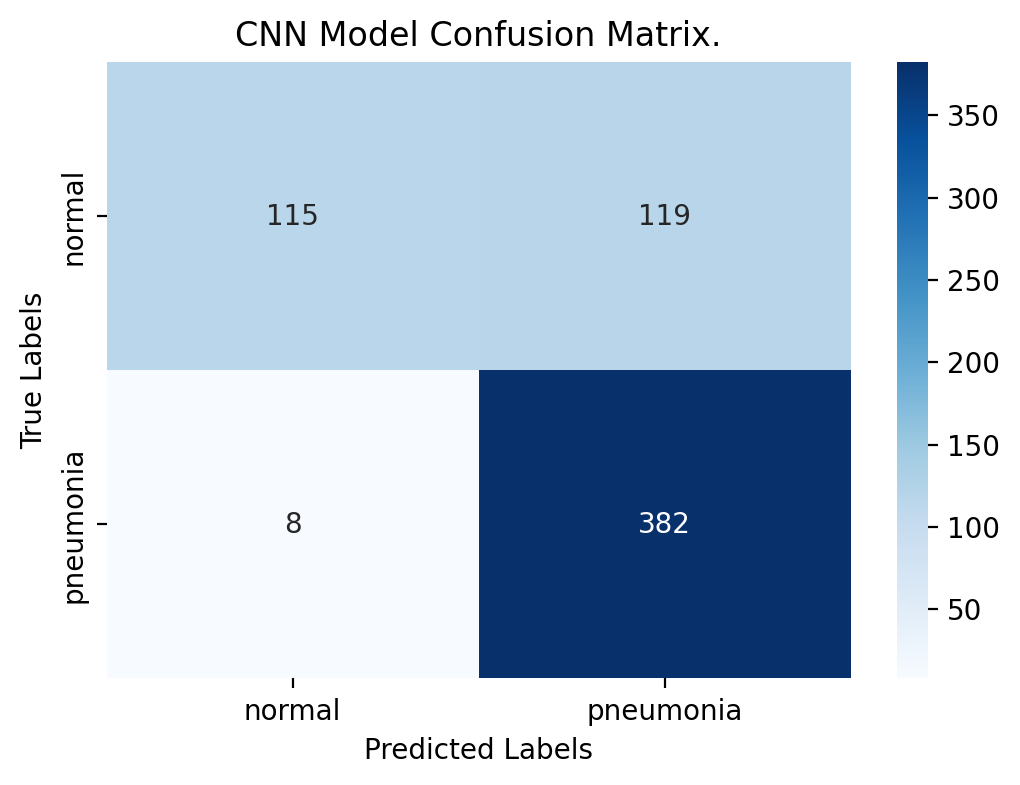

In [80]:
# Generate predictions for the test dataset
cnn_predictions_2 = cnn_model_2.predict(test_ds)
cnn_test_pred_2 = np.argmax(cnn_predictions_2, axis=-1)

# Extract true labels from 'test_ds'
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Map integer labels to class names for true labels
true_class_names = [class_names[label] for label in true_labels]

# Map integer labels to class names for predicted labels
predicted_class_names = [class_names[label] for label in cnn_test_pred_2]

# Calculate test accuracy
cnn_test_accuracy_adam = accuracy_score(true_labels, cnn_test_pred_2)

# Print the classification report
cnn_report_2 = classification_report(true_class_names, predicted_class_names, target_names=class_names)
print(cnn_report_2)

# Calculate and print the confusion matrix
cm_cnn_2 = confusion_matrix(true_class_names, predicted_class_names)

# Visualize the confusion matrix using a heatmap with class labels
plt.figure(dpi=200, figsize=(6, 4))
sns.heatmap(cm_cnn_2, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Model Confusion Matrix.')
plt.savefig("cnn_confusion_matrix_adam")
plt.show()


CNN Model:

ROC AUC Score: 0.9197
Sensitivity: 0.9846
Specificity: 0.4744


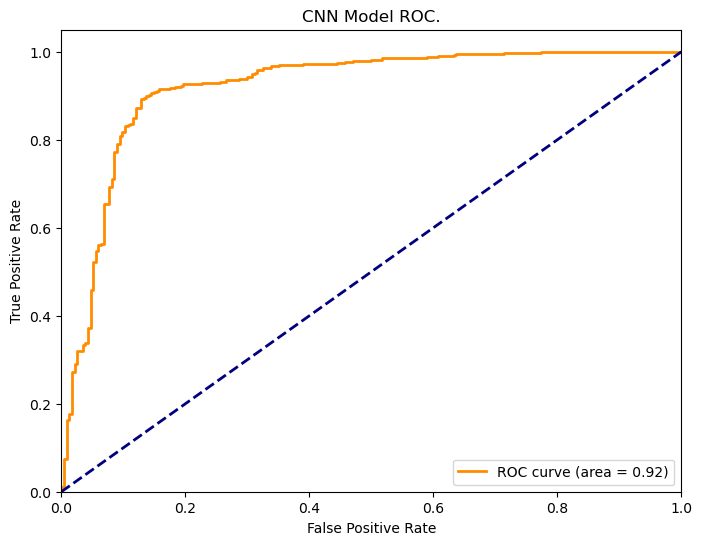

In [81]:
# Calculate the ROC curve
y_true = true_labels  # True labels
y_scores = cnn_predictions_2[:, 1]  # Predicted scores (assuming binary classification)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calculate ROC AUC
cnn_roc_auc_score_value_2 = roc_auc_score(y_true, y_scores)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true, np.round(y_scores)).ravel()

cnn_sensitivity_2 = tp / (tp + fn)
cnn_specificity_2 = tn / (tn + fp)

print("CNN Model:")
print()
print(f"ROC AUC Score: {cnn_roc_auc_score_value_2:.4f}")
print(f"Sensitivity: {cnn_sensitivity_2:.4f}")
print(f"Specificity: {cnn_specificity_2:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Model ROC.')
plt.legend(loc='lower right')
plt.savefig("cnn_roc_curve_adam.png")
plt.show()


#### Using SGD Activation Function

In [82]:
cnn_model_3 = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,
img_width, 3)),
layers.Conv2D(16, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding = "same", activation = "relu"),
layers.MaxPooling2D(),

layers.Flatten(),
layers.Dense(128, activation = "relu"),
Dropout(0.9),
layers.Dense(num_classes, activation = "sigmoid")
])

initial_learning_rate = 0.001
momentum = 0.9
optimizer = SGD(learning_rate=initial_learning_rate, momentum=momentum)

cnn_model_3.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"])
cnn_model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 512, 512, 3)       0         
                                                                 
 conv2d_47 (Conv2D)          (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 128, 128, 64)    

In [87]:
cnn_final_metrics_3 = early_train_and_get_final_metrics(cnn_model_3, train_ds, val_ds, epochs=10, patience=3)

# Access the final metrics as callable variables
cnn_loss_3 = cnn_final_metrics_3["Final Training Loss"]
cnn_accuracy_3 = cnn_final_metrics_3["Final Training Accuracy"]
cnn_val_loss_3 = cnn_final_metrics_3["Final Validation Loss"]
cnn_val_accuracy_3 = cnn_final_metrics_3["Final Validation Accuracy"]

print(f"Training Loss (CNN): {cnn_loss_3:.2f}")
print(f"Training Accuracy (CNN): {cnn_accuracy_3:.2f}")
print(f"Validation Loss (CNN): {cnn_val_loss_3:.2f}")
print(f"Validation Accuracy (CNN): {cnn_val_accuracy_3:.2f}")
history = cnn_final_metrics_3["History"]

Epoch 1/10
209/209 [==============================] - 10s 46ms/step - loss: 0.6928 - accuracy: 0.4809 - val_loss: 0.6499 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 2/10
209/209 [==============================] - 9s 45ms/step - loss: 0.5903 - accuracy: 0.6866 - val_loss: 0.4395 - val_accuracy: 0.9003 - lr: 0.0010
Epoch 3/10
209/209 [==============================] - 9s 45ms/step - loss: 0.4612 - accuracy: 0.7925 - val_loss: 0.2673 - val_accuracy: 0.9262 - lr: 0.0010
Epoch 4/10
209/209 [==============================] - 9s 45ms/step - loss: 0.3726 - accuracy: 0.8351 - val_loss: 0.2365 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 5/10
209/209 [==============================] - 9s 45ms/step - loss: 0.3289 - accuracy: 0.8696 - val_loss: 0.1470 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 6/10
209/209 [==============================] - 9s 45ms/step - loss: 0.2782 - accuracy: 0.8948 - val_loss: 0.1232 - val_accuracy: 0.9549 - lr: 9.0484e-04
Epoch 7/10
209/209 [==============================] - 9s 44

### Evaluating the Model

#### Making Plots for the model's loss and accuracy.

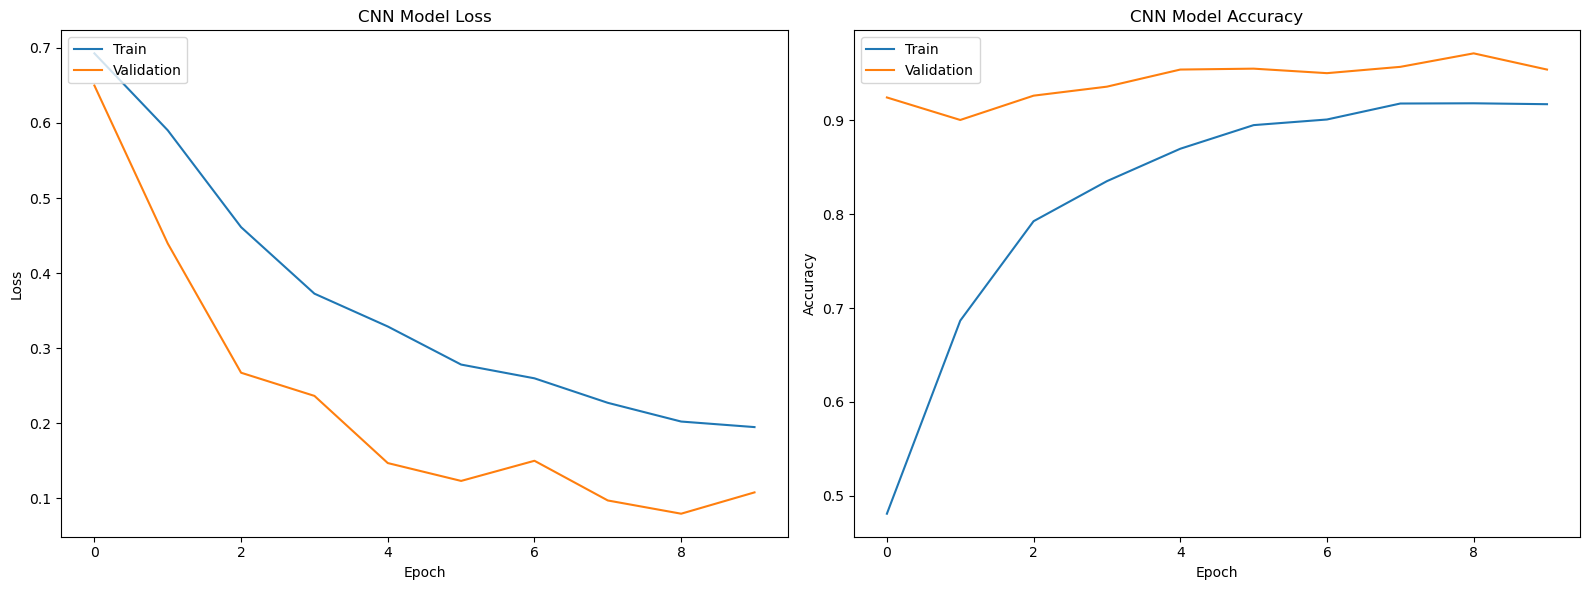

In [88]:
# Create a single figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot the first subplot (Model loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot the second subplot (Model accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the figure
plt.tight_layout()

# Save the figure as an image
plt.savefig("cnn_model_sgd")

plt.show()

#### Confusion Matrix

32/32 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

      normal       0.90      0.64      0.75       234
   pneumonia       0.82      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.82       624
weighted avg       0.85      0.84      0.83       624



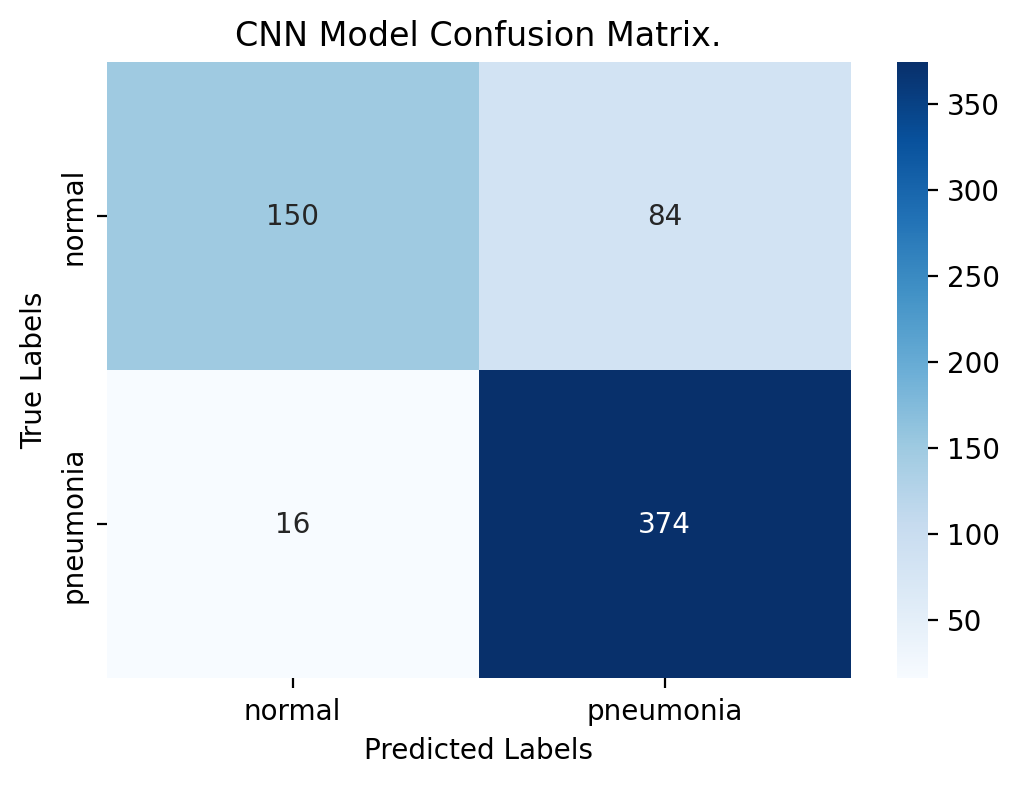

In [89]:
# Generate predictions for the test dataset
cnn_predictions_3 = cnn_model_3.predict(test_ds)
cnn_test_pred_3 = np.argmax(cnn_predictions_3, axis=-1)

# Extract true labels from 'test_ds'
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Map integer labels to class names for true labels
true_class_names = [class_names[label] for label in true_labels]

# Map integer labels to class names for predicted labels
predicted_class_names = [class_names[label] for label in cnn_test_pred_3]

# Calculate test accuracy
cnn_test_accuracy_sgd = accuracy_score(true_labels, cnn_test_pred_3)

# Print the classification report
cnn_report_3 = classification_report(true_class_names, predicted_class_names, target_names=class_names)
print(cnn_report_3)

# Calculate and print the confusion matrix
cm_cnn_3 = confusion_matrix(true_class_names, predicted_class_names)

# Visualize the confusion matrix using a heatmap with class labels
plt.figure(dpi=200, figsize=(6, 4))
sns.heatmap(cm_cnn_3, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Model Confusion Matrix.')
plt.savefig("cnn_confusion_matrix_sgd")
plt.show()


CNN Model:

ROC AUC Score: 0.9398
Sensitivity: 0.9513
Specificity: 0.7179


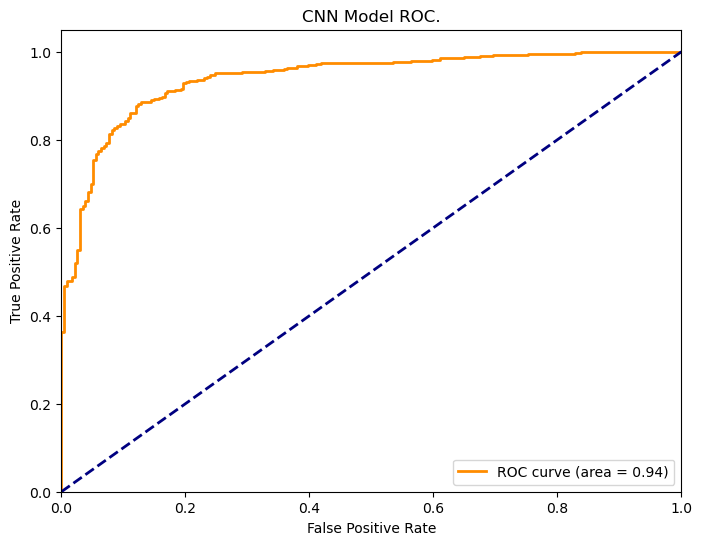

In [90]:
# Calculate the ROC curve
y_true = true_labels  # True labels
y_scores = cnn_predictions_3[:, 1]  # Predicted scores (assuming binary classification)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calculate ROC AUC
cnn_roc_auc_score_value_3 = roc_auc_score(y_true, y_scores)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true, np.round(y_scores)).ravel()

cnn_sensitivity_3 = tp / (tp + fn)
cnn_specificity_3 = tn / (tn + fp)

print("CNN Model:")
print()
print(f"ROC AUC Score: {cnn_roc_auc_score_value_3:.4f}")
print(f"Sensitivity: {cnn_sensitivity_3:.4f}")
print(f"Specificity: {cnn_specificity_3:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Model ROC.')
plt.legend(loc='lower right')
plt.savefig("cnn_roc_curve_sgd.png")
plt.show()


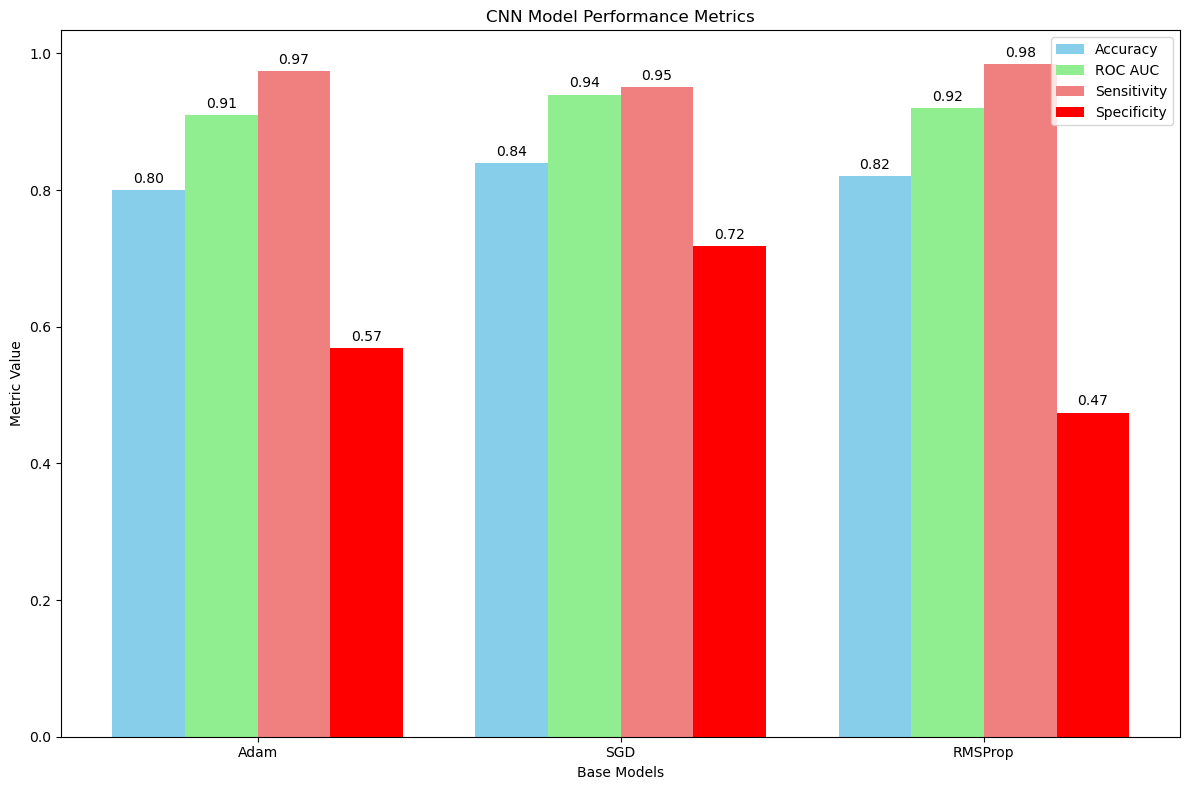

In [95]:
# Base model names
cnn_models = ["Adam", "SGD", "RMSProp"]

# Metrics
accuracy_list = [cnn_test_accuracy_adam, cnn_test_accuracy_sgd, cnn_test_accuracy_rms]
roc_auc_list = [cnn_roc_auc_score_value, cnn_roc_auc_score_value_3, cnn_roc_auc_score_value_2]
sensitivity_list = [cnn_sensitivity, cnn_sensitivity_3, cnn_sensitivity_2]
specificity_list = [cnn_specificity, cnn_specificity_3, cnn_specificity_2]

# Setting the width of the bars
bar_width = 0.2
index = range(len(cnn_models))

# Creating subplots for each metric
plt.figure(figsize = (12, 8))

# Plotting Accuracy
bar1 = plt.bar(index, accuracy_list, bar_width, label = "Accuracy", color = "skyblue", align = "center")
add_values(bar1)

# Plotting ROC AUC
bar2 = plt.bar([i + bar_width for i in index], roc_auc_list, bar_width, label = "ROC AUC", color = "lightgreen", 
               align = "center")
add_values(bar2)

# Plotting Sensitivity
bar3 = plt.bar([i + 2 * bar_width for i in index], sensitivity_list, bar_width, label = "Sensitivity", 
               color = "lightcoral", align = "center")
add_values(bar3)

# Plotting ROC AUC
bar4 = plt.bar([i + 3 * bar_width for i in index], specificity_list, bar_width, label = "Specificity", 
               color = "red", align = "center")
add_values(bar4)

# Setting the x-axis labels
plt.xlabel("Base Models")
plt.xticks([i + 1.5 * bar_width for i in index], cnn_models)

# Setting the y-axis labels
plt.ylabel("Metric Value")

# Setting the plot title
plt.title("CNN Model Performance Metrics")

# Setting the plot title
plt.legend()

# Showing the plot
plt.tight_layout()
plt.savefig("CNN_metric")
plt.show()

### Building the Hybrid Models.

#### Feature Extraction with CNN. 

In [96]:
# Create a dictionary to map class names to class labels
class_to_label = {class_name: label for label, class_name in enumerate(class_names)}

# Get the labels for the training dataset based on subfolder names
train_labels = []
for images, labels in train_ds.unbatch():
    class_name = class_names[labels]
    train_labels.append(class_to_label[class_name])

# Convert train_labels to a NumPy array
train_labels = np.array(train_labels)


In [97]:
# Define true labels for the validation and test datasets
val_true_labels = []  # Replace with actual validation set labels
test_true_labels = []  # Replace with actual test set labels

# You can load the true labels in a similar way as you did for the training set,
# based on the subfolder names or any other method you used to organize your data.

# Example for loading true labels for validation dataset (assuming it has the same structure as the training dataset)
for images, labels in val_ds.unbatch():
    class_name = class_names[labels]
    val_true_labels.append(class_to_label[class_name])

# Example for loading true labels for the test dataset (similar to validation)
for images, labels in test_ds.unbatch():
    class_name = class_names[labels]
    test_true_labels.append(class_to_label[class_name])


In [98]:
# 1. Feature Extraction with CNN
# Define a new model that outputs the CNN's output layer
cnn_feature_extractor = keras.Model(inputs=cnn_model_3.input, outputs=cnn_model_3.layers[-2].output)

# 2. Feature Extraction from Training Data
train_features = cnn_feature_extractor.predict(train_ds)
# Flatten the feature vectors
train_features = train_features.reshape(train_features.shape[0], -1)

# 3. Feature Extraction from Validation Data
val_features = cnn_feature_extractor.predict(val_ds)
# Flatten the feature vectors
val_features = val_features.reshape(val_features.shape[0], -1)

# 4. Feature Extraction from Test Data
test_features = cnn_feature_extractor.predict(test_ds)
# Flatten the feature vectors
test_features = test_features.reshape(test_features.shape[0], -1)

32/32 [==============================] - 1s 17ms/step


#### CNN-Random Forest Model

In [114]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=2000, random_state=123)

# Train the Random Forest classifier on the extracted features
rf_classifier.fit(train_features, train_labels)  # You need to have 'train_labels' defined

# 6. Evaluate the Random Forest Classifier on Validation and Test Data
val_predictions = rf_classifier.predict(val_features)
test_predictions = rf_classifier.predict(test_features)

In [115]:
# Evaluate the classifier on the validation set
val_accuracy = accuracy_score(val_true_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Evaluate the classifier on the test set
test_accuracy = accuracy_score(test_true_labels, test_predictions)
cnn_rf_acc = test_accuracy
print(f"Test Accuracy: {test_accuracy:.2f}")

Validation Accuracy: 0.77
Test Accuracy: 0.62



CNN-Random Forest Classification Report:
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       234
   pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



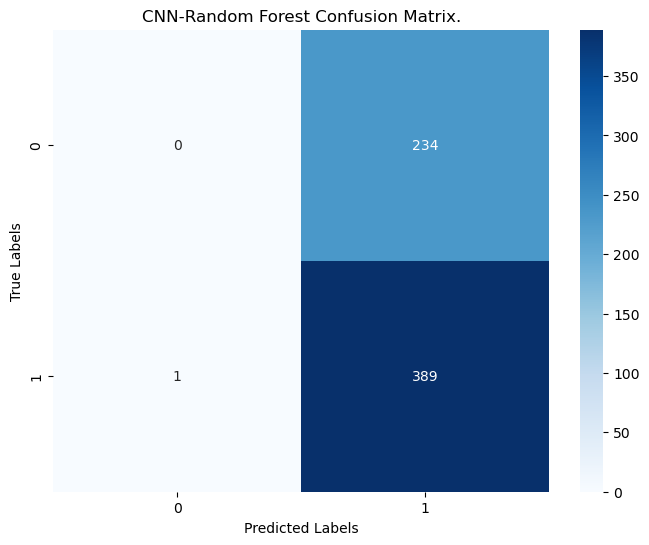

In [116]:
# Evaluate the classifier on the test set
test_predictions = rf_classifier.predict(test_features)
test_confusion_matrix = confusion_matrix(test_true_labels, test_predictions)
test_classification_report = classification_report(test_true_labels, test_predictions, target_names=class_names)


print("\nCNN-Random Forest Classification Report:")
print(test_classification_report)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("CNN-Random Forest Confusion Matrix.")
plt.savefig("cnn_rf_confusion_matrix")
plt.show()

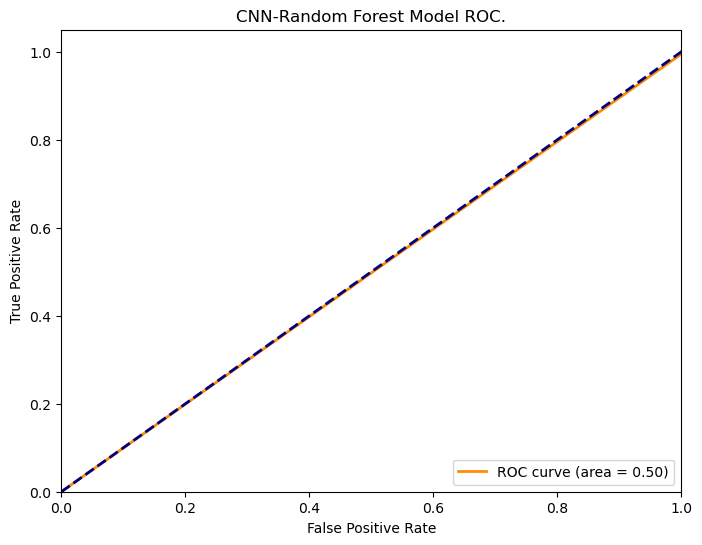

CNN-Random Forest Model:

CNN-Random Forest Sensitivity: 0.99
CNN-Random Forest Specificity: 0.00
CNN-Random Forest ROC AUC: 0.50


In [104]:
# 1. Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# 2. Calculate sensitivity (True Positive Rate) for the test set
cnn_rf_sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# 3. Calculate specificity (True Negative Rate) for the test set
cnn_rf_specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# 4. Calculate ROC curve for the test set
fpr, tpr, thresholds = roc_curve(test_true_labels, test_predictions)

# 5. Calculate ROC AUC (Area Under the ROC Curve) for the test set
cnn_rf_roc_auc = auc(fpr, tpr)

# 6. Plot the ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {cnn_rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN-Random Forest Model ROC.')
plt.legend(loc='lower right')
plt.savefig("CNN-Random_Forest_ROC")
plt.show()

# 7. Display sensitivity, specificity, and ROC AUC for the test set
print("CNN-Random Forest Model:")
print()
print(f"CNN-Random Forest Sensitivity: {cnn_rf_sensitivity:.2f}")
print(f"CNN-Random Forest Specificity: {cnn_rf_specificity:.2f}")
print(f"CNN-Random Forest ROC AUC: {cnn_rf_roc_auc:.2f}")

#### CNN-KNN Model

In [105]:
# 5. Train KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=2, p =2)  # You can adjust the number of neighbors (k) as needed
knn_classifier.fit(train_features, train_labels)  # You need to have 'train_labels' defined

# 6. Evaluate the Hybrid Model on Validation Data
val_predictions = knn_classifier.predict(val_features)
val_accuracy = accuracy_score(val_true_labels, val_predictions)  # You need to have 'val_true_labels' defined

# 7. Evaluate the Hybrid Model on Test Data
test_predictions = knn_classifier.predict(test_features)
test_accuracy = accuracy_score(test_true_labels, test_predictions)  # You need to have 'test_true_labels' defined

In [106]:
# Evaluate the classifier on the validation set
val_accuracy = accuracy_score(val_true_labels, val_predictions)
print(f"CNN-KNN Validation Accuracy: {val_accuracy:.2f}")

# Evaluate the classifier on the test set
test_accuracy = accuracy_score(test_true_labels, test_predictions)
cnn_knn_acc = test_accuracy
print(f"CNN-KNN Test Accuracy: {test_accuracy:.2f}")

CNN-KNN Validation Accuracy: 0.52
CNN-KNN Test Accuracy: 0.48



CNN-KNN Classification Report:
              precision    recall  f1-score   support

      normal       0.34      0.41      0.38       234
   pneumonia       0.60      0.52      0.56       390

    accuracy                           0.48       624
   macro avg       0.47      0.47      0.47       624
weighted avg       0.50      0.48      0.49       624



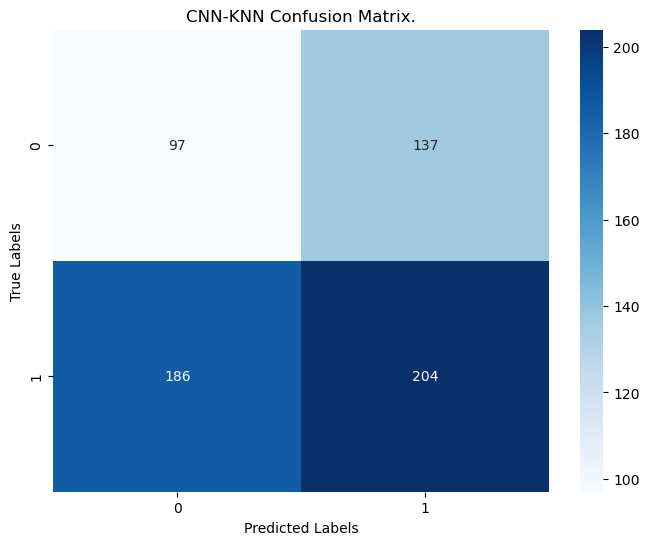

In [107]:
test_confusion_matrix = confusion_matrix(test_true_labels, test_predictions)
test_classification_report = classification_report(test_true_labels, test_predictions, target_names=class_names)


print("\nCNN-KNN Classification Report:")
print(test_classification_report)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("CNN-KNN Confusion Matrix.")
plt.savefig("cnn_knn_confusion_matrix")
plt.show()

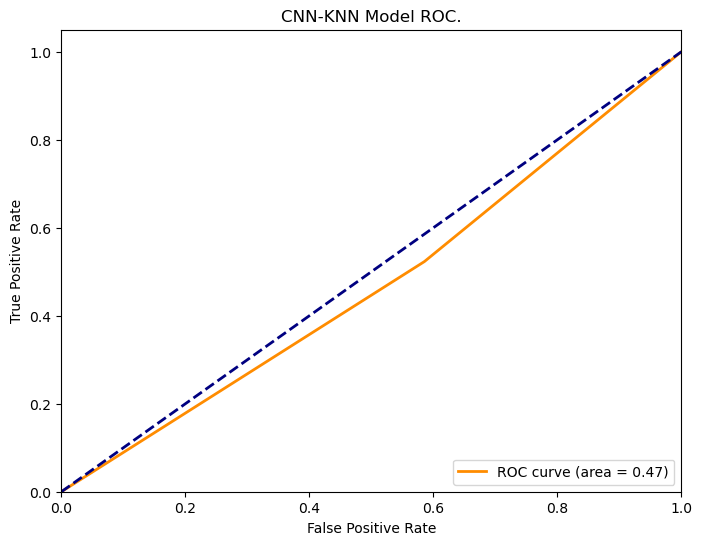

CNN-KNN Model:

CNN-KNN Sensitivity: 0.52
CNN-KNN Specificity: 0.41
CNN-KNN ROC AUC: 0.47


In [108]:
# 1. Calculate the confusion matrix for the test set
ck_conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# 2. Calculate sensitivity (True Positive Rate) for the test set
cnn_knn_sensitivity = ck_conf_matrix[1, 1] / (ck_conf_matrix[1, 0] + ck_conf_matrix[1, 1])

# 3. Calculate specificity (True Negative Rate) for the test set
cnn_knn_specificity = ck_conf_matrix[0, 0] / (ck_conf_matrix[0, 0] + ck_conf_matrix[0, 1])

# 4. Calculate ROC curve for the test set
fpr, tpr, thresholds = roc_curve(test_true_labels, test_predictions)

# 5. Calculate ROC AUC (Area Under the ROC Curve) for the test set
cnn_ck_roc_auc = auc(fpr, tpr)

# 6. Plot the ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {cnn_ck_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN-KNN Model ROC.')
plt.legend(loc='lower right')
plt.savefig("CNN-KNN_ROC")
plt.show()

# 7. Display sensitivity, specificity, and ROC AUC for the test set
print("CNN-KNN Model:")
print()
print(f"CNN-KNN Sensitivity: {cnn_knn_sensitivity:.2f}")
print(f"CNN-KNN Specificity: {cnn_knn_specificity:.2f}")
print(f"CNN-KNN ROC AUC: {cnn_ck_roc_auc:.2f}")

#### CNN-Decision Trees Model

In [109]:
# 5. Build and Train a Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=123)

# Train the Decision Tree classifier on the extracted features
decision_tree_classifier.fit(train_features, train_labels)  # You need to have 'train_labels' defined

# 6. Evaluate the Decision Tree Classifier on Validation and Test Data
val_predictions = decision_tree_classifier.predict(val_features)
test_predictions = decision_tree_classifier.predict(test_features)

# Evaluate the classifier on the validation set
val_accuracy = accuracy_score(val_true_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Evaluate the classifier on the test set
test_accuracy = accuracy_score(test_true_labels, test_predictions)
cnn_dt_acc = test_accuracy
print(f"Test Accuracy: {test_accuracy:.2f}")

Validation Accuracy: 0.63
Test Accuracy: 0.58



CNN-Decision Trees Classification Report:
              precision    recall  f1-score   support

      normal       0.42      0.30      0.35       234
   pneumonia       0.64      0.75      0.69       390

    accuracy                           0.58       624
   macro avg       0.53      0.53      0.52       624
weighted avg       0.56      0.58      0.56       624



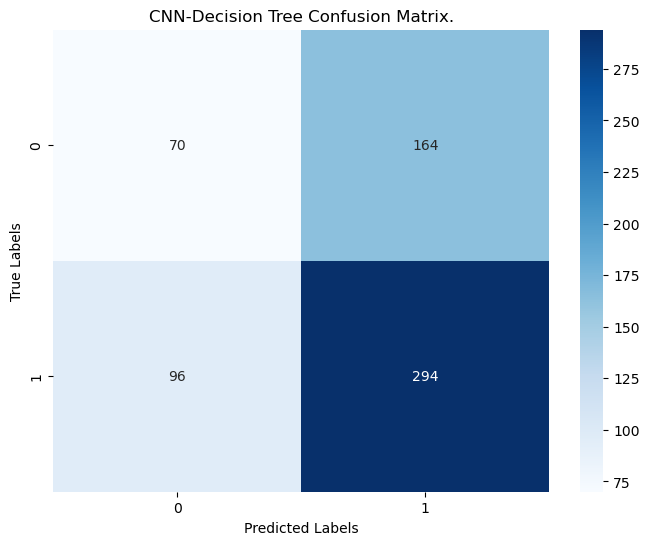

In [110]:
# You can also calculate and print the confusion matrix and classification report for more details
test_confusion_matrix = confusion_matrix(test_true_labels, test_predictions)
test_classification_report = classification_report(test_true_labels, test_predictions, target_names=class_names)

print("\nCNN-Decision Trees Classification Report:")
print(test_classification_report)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("CNN-Decision Tree Confusion Matrix.")
plt.savefig("cnn_dt_confusion_matrix")
plt.show()

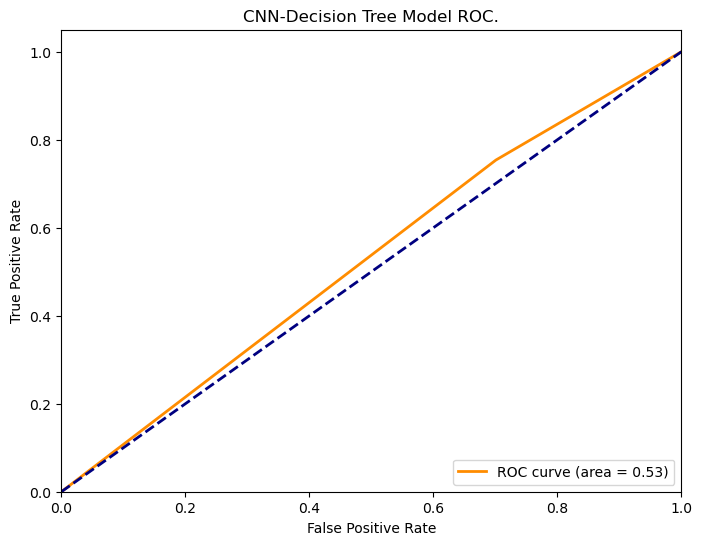

CNN-Decision Tree Model:

CNN-Decision Tree Sensitivity: 0.75
CNN-Decision Tree Specificity: 0.30
CNN-Decision Tree ROC AUC: 0.53


In [111]:
# 1. Calculate the confusion matrix for the test set
dt_conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# 2. Calculate sensitivity (True Positive Rate) for the test set
cnn_dt_sensitivity = dt_conf_matrix[1, 1] / (dt_conf_matrix[1, 0] + dt_conf_matrix[1, 1])

# 3. Calculate specificity (True Negative Rate) for the test set
cnn_dt_specificity = dt_conf_matrix[0, 0] / (dt_conf_matrix[0, 0] + dt_conf_matrix[0, 1])

# 4. Calculate ROC curve for the test set
fpr, tpr, thresholds = roc_curve(test_true_labels, test_predictions)

# 5. Calculate ROC AUC (Area Under the ROC Curve) for the test set
cnn_dt_roc_auc = auc(fpr, tpr)

# 6. Plot the ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {cnn_dt_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN-Decision Tree Model ROC.')
plt.legend(loc='lower right')
plt.savefig("CNN-dt_ROC")
plt.show()

# 7. Display sensitivity, specificity, and ROC AUC for the test set
print("CNN-Decision Tree Model:")
print()
print(f"CNN-Decision Tree Sensitivity: {cnn_dt_sensitivity:.2f}")
print(f"CNN-Decision Tree Specificity: {cnn_dt_specificity:.2f}")
print(f"CNN-Decision Tree ROC AUC: {cnn_dt_roc_auc:.2f}")

### Transfer Learning Model

#### Building the Model Using Pre-Trained Model ResNet50.

In [174]:
# Define the input shape and number of classes


# Create a pre-trained ResNet50 model
pretrained_model = ResNet50(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3), pooling='max')
pretrained_model.trainable = False

# Build the custom model on top of the ResNet50 base
model = Sequential([
    pretrained_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
          activity_regularizer=tf.keras.regularizers.l1(0.003),
          bias_regularizer=tf.keras.regularizers.l1(0.003),
          activation='relu'),
    Dropout(rate=0.9, seed=123),
    Dense(2, activation='sigmoid')  # Using a single output neuron for binary classification
])

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

# Summary of the model
model.summary()

# Define epochs
epochs = 50

# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    verbose=1,
    validation_data=val_ds,
    shuffle=False,
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_8 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_42 (Dense)            (None, 256)               524544    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 2)                 514       
                                                                 
Total params: 24,120,962
Trainable params: 529,154
Non-trainable params: 23,591,808
___________________________________

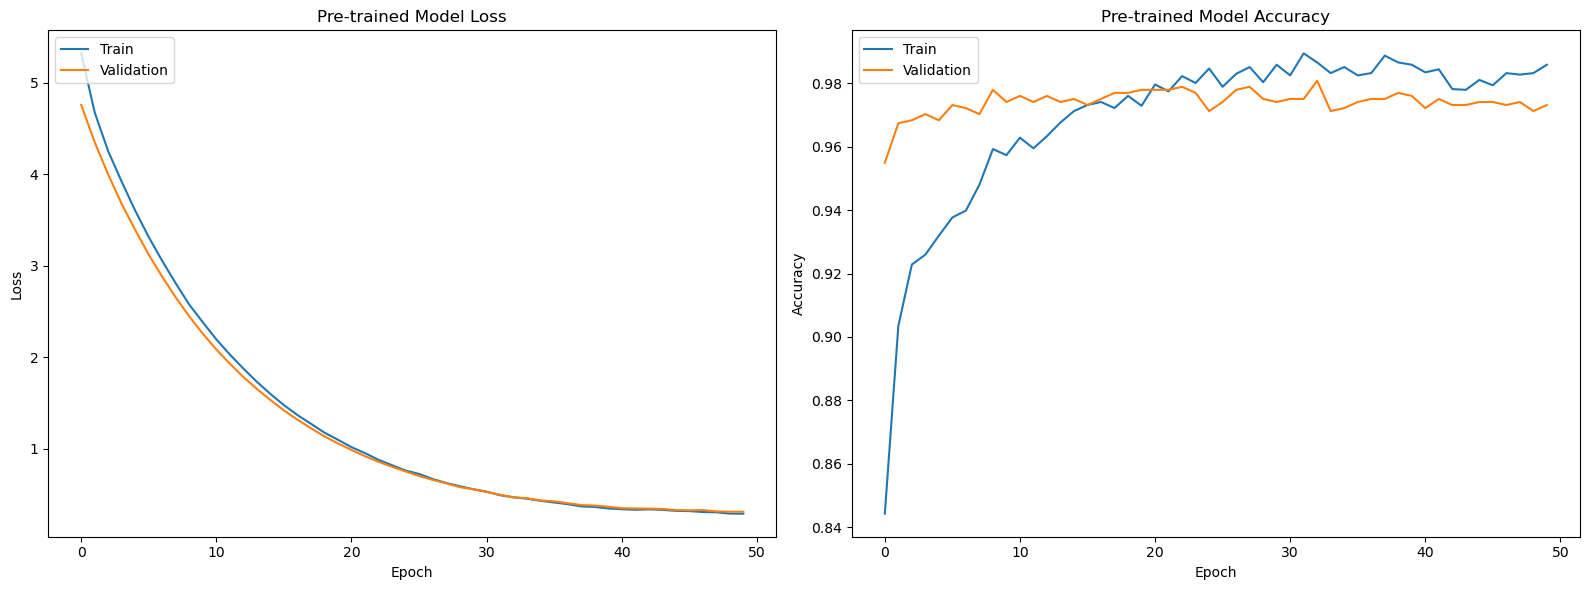

In [175]:
# Create a single figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot the first subplot (Model loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pre-trained Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot the second subplot (Model accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Pre-trained Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the figure
plt.tight_layout()

# Save the figure as an image
plt.savefig("pretrained_model_loss")

plt.show()

32/32 [==============================] - 3s 87ms/step
              precision    recall  f1-score   support

      normal       0.96      0.54      0.69       234
   pneumonia       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



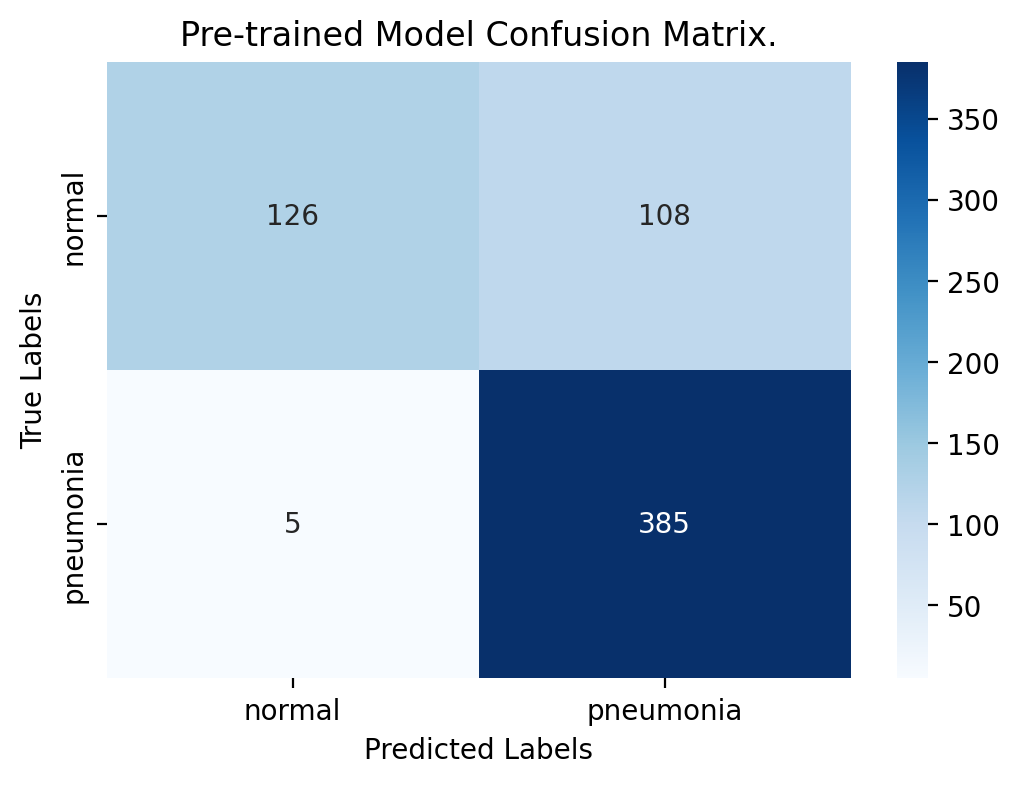

In [178]:
# Generate predictions for the test dataset
pt_predictions = model.predict(test_ds)
pt_test_pred = np.argmax(pt_predictions, axis=-1)

# Extract true labels from 'test_ds'
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Map integer labels to class names for true labels
true_class_names = [class_names[label] for label in true_labels]

# Map integer labels to class names for predicted labels
predicted_class_names = [class_names[label] for label in pt_test_pred]

# Calculate test accuracy
pt_test_accuracy = accuracy_score(true_labels, pt_test_pred)

# Print the classification report
pt_report = classification_report(true_class_names, predicted_class_names, target_names=class_names)
print(pt_report)

# Calculate and print the confusion matrix
cm_pt = confusion_matrix(true_class_names, predicted_class_names)

# Visualize the confusion matrix using a heatmap with class labels
plt.figure(dpi=200, figsize=(6, 4))
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Pre-trained Model Confusion Matrix.')
plt.savefig("pt_confusion_matrix")
plt.show()

CNN Model:

ROC AUC Score: 0.9374
Sensitivity: 0.9923
Specificity: 0.5342


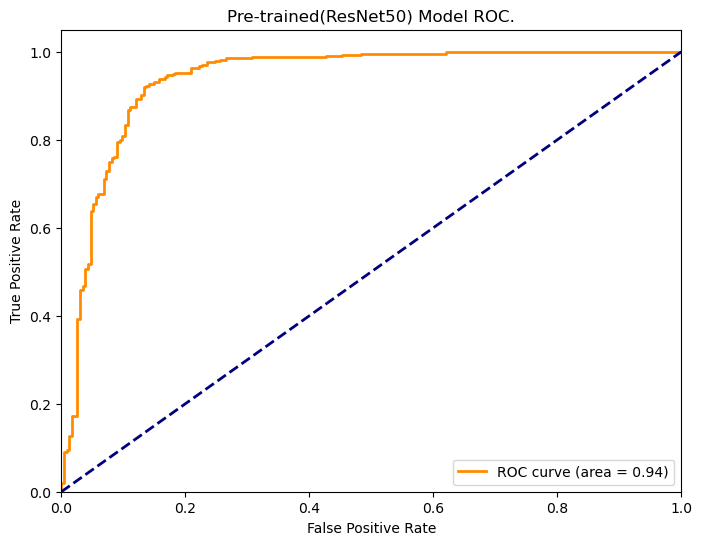

In [177]:
# Calculate the ROC curve
y_true = true_labels  # True labels
y_scores = pt_predictions[:, 1]  # Predicted scores (assuming binary classification)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calculate ROC AUC
pt_roc_auc_score_value = roc_auc_score(y_true, y_scores)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true, np.round(y_scores)).ravel()

pt_sensitivity = tp / (tp + fn)
pt_specificity = tn / (tn + fp)

print("CNN Model:")
print()
print(f"ROC AUC Score: {pt_roc_auc_score_value:.4f}")
print(f"Sensitivity: {pt_sensitivity:.4f}")
print(f"Specificity: {pt_specificity:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pre-trained(ResNet50) Model ROC.')
plt.legend(loc='lower right')
plt.savefig("pt_roc_curve.png")
plt.show()

#### Model Metrics Plot

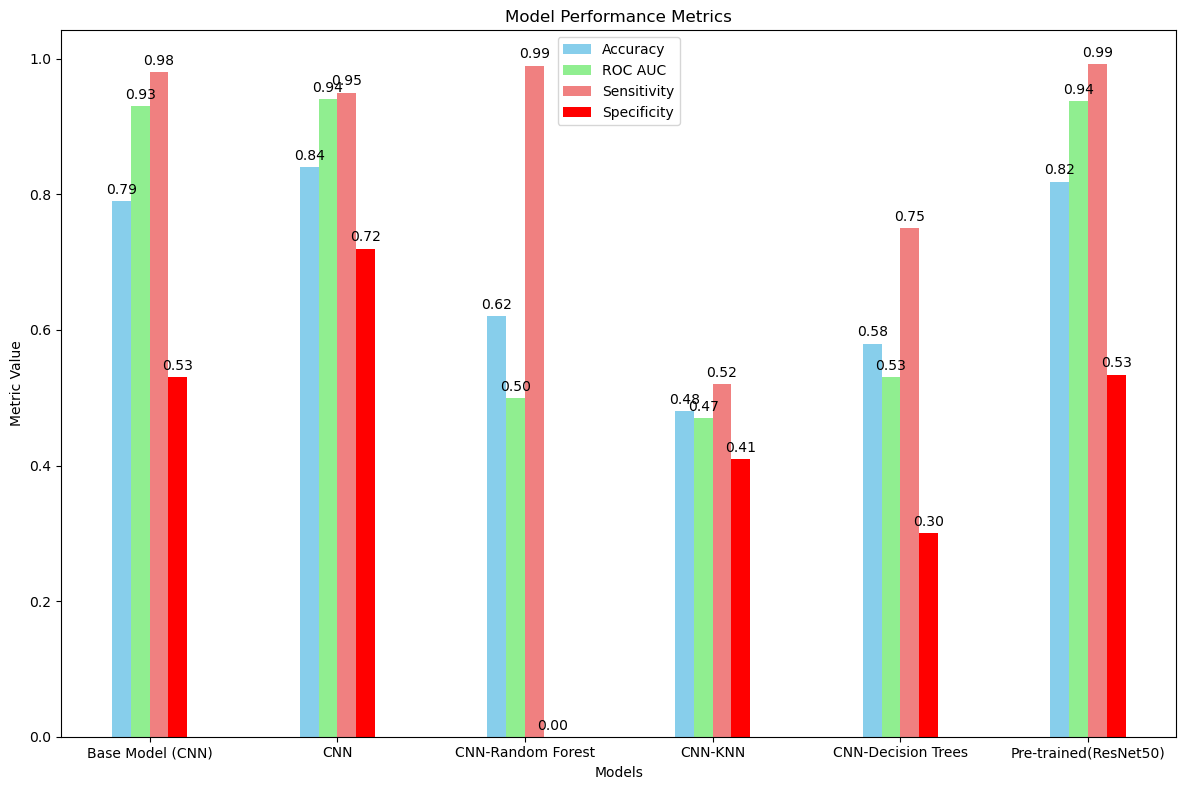

In [180]:
# All model names
all_models = ["Base Model (CNN)", "CNN", "CNN-Random Forest", "CNN-KNN", "CNN-Decision Trees", "Pre-trained(ResNet50)"]

# Metrics
accuracy_list = [base_test_accuracy_sgd, cnn_test_accuracy_sgd, cnn_rf_acc, cnn_knn_acc, cnn_dt_acc, pt_test_accuracy]
roc_auc_list = [sgd_roc_auc_score_value, cnn_roc_auc_score_value_3, cnn_rf_roc_auc, cnn_ck_roc_auc, cnn_dt_roc_auc, 
                pt_roc_auc_score_value]
sensitivity_list = [sgd_sensitivity, cnn_sensitivity_3, cnn_rf_sensitivity, cnn_knn_sensitivity, cnn_dt_sensitivity, 
                    pt_sensitivity]
specificity_list = [sgd_specificity, cnn_specificity_3, cnn_rf_specificity, cnn_knn_specificity, cnn_dt_specificity, 
                    pt_specificity]

# Setting the width of the bars
bar_width = 0.1
index = range(len(all_models))

# Creating subplots for each metric
plt.figure(figsize = (12, 8))

# Plotting Accuracy
bar1 = plt.bar(index, accuracy_list, bar_width, label = "Accuracy", color = "skyblue", align = "center")
add_values(bar1)

# Plotting ROC AUC
bar2 = plt.bar([i + bar_width for i in index], roc_auc_list, bar_width, label = "ROC AUC", color = "lightgreen", 
               align = "center")
add_values(bar2)

# Plotting Sensitivity
bar3 = plt.bar([i + 2 * bar_width for i in index], sensitivity_list, bar_width, label = "Sensitivity", 
               color = "lightcoral", align = "center")
add_values(bar3)

# Plotting ROC AUC
bar4 = plt.bar([i + 3 * bar_width for i in index], specificity_list, bar_width, label = "Specificity", 
               color = "red", align = "center")
add_values(bar4)

# Setting the x-axis labels
plt.xlabel("Models")
plt.xticks([i + 1.5 * bar_width for i in index], all_models)

# Setting the y-axis labels
plt.ylabel("Metric Value")

# Setting the plot title
plt.title("Model Performance Metrics")

# Setting the plot title
plt.legend()

# Showing the plot
plt.tight_layout()
plt.savefig("all_model_metric")
plt.show()